In [1]:
!wget https://huggingface.co/datasets/puhsu/tabular-benchmarks/resolve/main/data.tar -O tabular-dl-tabr.tar.gz
!tar -xvf tabular-dl-tabr.tar.gz

--2024-10-15 11:11:54--  https://huggingface.co/datasets/puhsu/tabular-benchmarks/resolve/main/data.tar
Resolving huggingface.co (huggingface.co)... 18.244.202.60, 18.244.202.118, 18.244.202.68, ...
Connecting to huggingface.co (huggingface.co)|18.244.202.60|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/1b/25/1b25d6e2556c827abfaf6ba9da6021338691cafc39fe9d77986955ae0a69243d/0d74e4b96febb48fbe4dd2d851f8638b5738354f82c3183f92adbd2abf2f256b?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27data.tar%3B+filename%3D%22data.tar%22%3B&response-content-type=application%2Fx-tar&Expires=1729249914&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyOTI0OTkxNH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8xYi8yNS8xYjI1ZDZlMjU1NmM4MjdhYmZhZjZiYTlkYTYwMjEzMzg2OTFjYWZjMzlmZTlkNzc5ODY5NTVhZTBhNjkyNDNkLzBkNzRlNGI5NmZlYmI0OGZiZTRkZDJkODUxZjg2MzhiNTczODM1NGY4MmMzMTgzZjkyYWRiZDJhYmYyZjI

In [2]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.7 MB/s eta 0:00:00


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import optuna
import torch.optim

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import QuantileTransformer

In [5]:
tnr = TabNetRegressor()

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [6]:
X_train = np.load('/content/data/regression-num-medium-0-houses/X_num_train.npy')
y_train = np.load('/content/data/regression-num-medium-0-houses/Y_train.npy').reshape(-1, 1)

X_valid = np.load('/content/data/regression-num-medium-0-houses/X_num_val.npy')
y_valid = np.load('/content/data/regression-num-medium-0-houses/Y_val.npy').reshape(-1, 1)

X_test = np.load('/content/data/regression-num-medium-0-houses/X_num_test.npy')
y_test = np.load('/content/data/regression-num-medium-0-houses/Y_test.npy').reshape(-1, 1)

In [7]:
normalizer = QuantileTransformer(
            output_distribution='normal',
            n_quantiles=max(min(X_train.shape[0] // 30, 1000), 10),
            subsample=1_000_000_000,
            )
normalizer.fit_transform(X_train)

array([[ 5.1993375 ,  0.19758019,  1.2819047 , ...,  0.39101908,
         0.56026226, -1.4062883 ],
       [ 1.0876423 , -1.0403167 ,  0.7731656 , ...,  0.41970792,
         1.086838  , -1.1877301 ],
       [ 0.900424  , -0.30279225, -0.3982458 , ..., -0.7325131 ,
        -0.7325131 ,  0.7776982 ],
       ...,
       [-0.95394254, -0.30279225,  0.5515898 , ...,  0.84323615,
        -2.0318518 ,  1.5784693 ],
       [-0.95394254, -0.6095368 , -1.3299519 , ..., -1.2430336 ,
         0.3215784 , -0.26943094],
       [ 0.5209385 , -0.5383124 , -0.8256636 , ..., -1.0599736 ,
         1.1725812 , -0.45711386]], dtype=float32)

In [8]:
#Baseline
tnr.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mae', 'rmse'],
)

epoch 0  | loss: 119.72114| train_mae: 18.196269989013672| train_rmse: 18.36054039001465| valid_mae: 18.17620086669922| valid_rmse: 18.341190338134766|  0:00:03s
epoch 1  | loss: 56.94198| train_mae: 67.64131927490234| train_rmse: 67.88523864746094| valid_mae: 67.5953598022461| valid_rmse: 67.8174819946289|  0:00:03s
epoch 2  | loss: 12.14867| train_mae: 181.90896606445312| train_rmse: 182.11813354492188| valid_mae: 181.6089630126953| valid_rmse: 181.9517059326172|  0:00:04s
epoch 3  | loss: 3.97199 | train_mae: 132.9217529296875| train_rmse: 133.19354248046875| valid_mae: 132.9796600341797| valid_rmse: 133.26284790039062|  0:00:05s
epoch 4  | loss: 1.30861 | train_mae: 187.6407012939453| train_rmse: 187.92210388183594| valid_mae: 187.54623413085938| valid_rmse: 187.79681396484375|  0:00:06s
epoch 5  | loss: 0.75816 | train_mae: 130.90032958984375| train_rmse: 131.1944580078125| valid_mae: 130.7469940185547| valid_rmse: 131.01199340820312|  0:00:06s
epoch 6  | loss: 0.4557  | train_mae

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [9]:
def objective(trial):
    n_d = trial.suggest_int('n_d', 8, 64)
    n_a = n_d

    params = {
        #'n_d': trial.suggest_int('n_d', 8, 64),
        #'n_a': trial.suggest_int('n_a', 8, 64),
        'n_d': n_d,
        'n_a': n_a,
        'n_steps': trial.suggest_int('n_steps', 3, 10),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'n_independent': trial.suggest_int('n_independent', 1, 5),
        'n_shared': trial.suggest_int('n_shared', 1, 5),
        'momentum': trial.suggest_float('momentum', 0.01, 0.4),
    }

    model = TabNetRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], patience=10)

    # Evaluate model performance
    score = model.best_cost  # or any other metric

    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2024-10-15 11:12:50,407] A new study created in memory with name: no-name-7f2b7437-00da-4867-88b6-57e6e8a227fb
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 68.52406| val_0_mse: 16831.72265625|  0:00:01s
epoch 1  | loss: 7.44925 | val_0_mse: 61428.3515625|  0:00:03s
epoch 2  | loss: 5.82488 | val_0_mse: 21581.439453125|  0:00:05s
epoch 3  | loss: 3.44415 | val_0_mse: 17933.81640625|  0:00:07s
epoch 4  | loss: 3.95225 | val_0_mse: 6629.34716796875|  0:00:08s
epoch 5  | loss: 3.79965 | val_0_mse: 4497.40673828125|  0:00:10s
epoch 6  | loss: 2.88478 | val_0_mse: 1417.0181884765625|  0:00:12s
epoch 7  | loss: 8.69818 | val_0_mse: 1241.676513671875|  0:00:13s
epoch 8  | loss: 1.55253 | val_0_mse: 251.8632354736328|  0:00:15s
epoch 9  | loss: 1.17761 | val_0_mse: 393.4658508300781|  0:00:17s
epoch 10 | loss: 1.52531 | val_0_mse: 544.6976318359375|  0:00:19s
epoch 11 | loss: 2.32103 | val_0_mse: 562.0308837890625|  0:00:20s
epoch 12 | loss: 2.00032 | val_0_mse: 379.9363708496094|  0:00:22s
epoch 13 | loss: 1.04612 | val_0_mse: 268.2509460449219|  0:00:24s
epoch 14 | loss: 1.54981 | val_0_mse: 96.57469940185547|  0:00:25s
epoch 15

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:14:35,183] Trial 0 finished with value: 0.16888196766376495 and parameters: {'n_d': 42, 'n_steps': 10, 'gamma': 1.4984488351630505, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.03503733376112773}. Best is trial 0 with value: 0.16888196766376495.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 64.65764| val_0_mse: 253206.984375|  0:00:01s
epoch 1  | loss: 3.32787 | val_0_mse: 5503.8173828125|  0:00:02s
epoch 2  | loss: 3.16464 | val_0_mse: 29989.36328125|  0:00:03s
epoch 3  | loss: 1.74983 | val_0_mse: 4553.85400390625|  0:00:05s
epoch 4  | loss: 0.7659  | val_0_mse: 1153.7091064453125|  0:00:06s
epoch 5  | loss: 1.17989 | val_0_mse: 1059.1920166015625|  0:00:07s
epoch 6  | loss: 0.82339 | val_0_mse: 282.9734802246094|  0:00:09s
epoch 7  | loss: 0.38877 | val_0_mse: 507.0717468261719|  0:00:10s
epoch 8  | loss: 0.35704 | val_0_mse: 274.5067443847656|  0:00:11s
epoch 9  | loss: 0.36699 | val_0_mse: 377.7467346191406|  0:00:13s
epoch 10 | loss: 0.41735 | val_0_mse: 268.4640808105469|  0:00:14s
epoch 11 | loss: 0.43722 | val_0_mse: 36.11714172363281|  0:00:15s
epoch 12 | loss: 0.33481 | val_0_mse: 130.6616973876953|  0:00:16s
epoch 13 | loss: 0.31982 | val_0_mse: 126.85266876220703|  0:00:18s
epoch 14 | loss: 0.31901 | val_0_mse: 255.60313415527344|  0:00:19s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:16:35,743] Trial 1 finished with value: 0.12759467959403992 and parameters: {'n_d': 57, 'n_steps': 7, 'gamma': 1.535307161324784, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.14238175249363208}. Best is trial 1 with value: 0.12759467959403992.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 61.15518| val_0_mse: 250577.90625|  0:00:01s
epoch 1  | loss: 5.24302 | val_0_mse: 19424.201171875|  0:00:02s
epoch 2  | loss: 1.30424 | val_0_mse: 7075.7470703125|  0:00:03s
epoch 3  | loss: 0.81674 | val_0_mse: 3264.983642578125|  0:00:04s
epoch 4  | loss: 0.56482 | val_0_mse: 1870.60986328125|  0:00:05s
epoch 5  | loss: 0.42857 | val_0_mse: 640.31005859375|  0:00:06s
epoch 6  | loss: 0.3855  | val_0_mse: 750.6838989257812|  0:00:07s
epoch 7  | loss: 0.31526 | val_0_mse: 220.97105407714844|  0:00:08s
epoch 8  | loss: 0.26519 | val_0_mse: 212.90208435058594|  0:00:09s
epoch 9  | loss: 0.23458 | val_0_mse: 109.98059844970703|  0:00:10s
epoch 10 | loss: 0.21702 | val_0_mse: 51.86043167114258|  0:00:11s
epoch 11 | loss: 0.21785 | val_0_mse: 14.781769752502441|  0:00:12s
epoch 12 | loss: 0.22194 | val_0_mse: 9.633600234985352|  0:00:14s
epoch 13 | loss: 0.21473 | val_0_mse: 6.638840198516846|  0:00:15s
epoch 14 | loss: 0.17328 | val_0_mse: 15.164839744567871|  0:00:16s
ep

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:17:08,211] Trial 2 finished with value: 2.0641977787017822 and parameters: {'n_d': 16, 'n_steps': 5, 'gamma': 1.318887539156387, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.3800263992804687}. Best is trial 1 with value: 0.12759467959403992.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 119.54294| val_0_mse: 122693.921875|  0:00:01s
epoch 1  | loss: 31.27798| val_0_mse: 56191.328125|  0:00:02s
epoch 2  | loss: 7.26752 | val_0_mse: 100771.0546875|  0:00:03s
epoch 3  | loss: 3.77946 | val_0_mse: 23025.98828125|  0:00:03s
epoch 4  | loss: 1.8367  | val_0_mse: 3883.533203125|  0:00:04s
epoch 5  | loss: 1.75827 | val_0_mse: 5844.2548828125|  0:00:06s
epoch 6  | loss: 0.93545 | val_0_mse: 6141.09228515625|  0:00:07s
epoch 7  | loss: 0.92109 | val_0_mse: 16803.705078125|  0:00:08s
epoch 8  | loss: 0.80024 | val_0_mse: 737.5097045898438|  0:00:09s
epoch 9  | loss: 0.81598 | val_0_mse: 578.6539306640625|  0:00:10s
epoch 10 | loss: 0.74868 | val_0_mse: 695.4750366210938|  0:00:11s
epoch 11 | loss: 0.32037 | val_0_mse: 687.8184814453125|  0:00:12s
epoch 12 | loss: 0.29022 | val_0_mse: 128.7975311279297|  0:00:13s
epoch 13 | loss: 0.278   | val_0_mse: 157.9763641357422|  0:00:14s
epoch 14 | loss: 0.25627 | val_0_mse: 9.608650207519531|  0:00:15s
epoch 15 | loss: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:18:50,156] Trial 3 finished with value: 0.09995829313993454 and parameters: {'n_d': 10, 'n_steps': 7, 'gamma': 1.9033357159726578, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.23180238687965868}. Best is trial 3 with value: 0.09995829313993454.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 44.661  | val_0_mse: 223864.53125|  0:00:01s
epoch 1  | loss: 3.7685  | val_0_mse: 32088.173828125|  0:00:03s
epoch 2  | loss: 4.3001  | val_0_mse: 5257.61669921875|  0:00:04s
epoch 3  | loss: 2.24814 | val_0_mse: 16443.458984375|  0:00:06s
epoch 4  | loss: 1.52382 | val_0_mse: 30945.572265625|  0:00:07s
epoch 5  | loss: 1.50152 | val_0_mse: 584.89990234375|  0:00:09s
epoch 6  | loss: 0.69518 | val_0_mse: 2671.52099609375|  0:00:10s
epoch 7  | loss: 0.50719 | val_0_mse: 22.5869197845459|  0:00:12s
epoch 8  | loss: 0.45442 | val_0_mse: 61.27069854736328|  0:00:13s
epoch 9  | loss: 0.66816 | val_0_mse: 126.8984375|  0:00:15s
epoch 10 | loss: 1.164   | val_0_mse: 428.2922668457031|  0:00:17s
epoch 11 | loss: 1.46027 | val_0_mse: 223.63255310058594|  0:00:18s
epoch 12 | loss: 0.72608 | val_0_mse: 55.5955696105957|  0:00:20s
epoch 13 | loss: 0.55458 | val_0_mse: 24.024599075317383|  0:00:21s
epoch 14 | loss: 0.66249 | val_0_mse: 23.906719207763672|  0:00:23s
epoch 15 | loss

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:19:18,658] Trial 4 finished with value: 22.586923599243164 and parameters: {'n_d': 53, 'n_steps': 10, 'gamma': 1.244505821704345, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.20083607661462993}. Best is trial 3 with value: 0.09995829313993454.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 62.21692| val_0_mse: 167664.9375|  0:00:01s
epoch 1  | loss: 6.89918 | val_0_mse: 9603.681640625|  0:00:02s
epoch 2  | loss: 2.22222 | val_0_mse: 9171.76171875|  0:00:04s
epoch 3  | loss: 1.02408 | val_0_mse: 1107.252197265625|  0:00:05s
epoch 4  | loss: 0.82396 | val_0_mse: 1537.5054931640625|  0:00:07s
epoch 5  | loss: 0.68244 | val_0_mse: 1338.8555908203125|  0:00:08s
epoch 6  | loss: 0.51505 | val_0_mse: 568.1080932617188|  0:00:09s
epoch 7  | loss: 0.4284  | val_0_mse: 467.0436096191406|  0:00:11s
epoch 8  | loss: 0.40321 | val_0_mse: 248.60064697265625|  0:00:12s
epoch 9  | loss: 0.79358 | val_0_mse: 374.1790466308594|  0:00:14s
epoch 10 | loss: 0.35613 | val_0_mse: 417.78369140625|  0:00:15s
epoch 11 | loss: 0.27386 | val_0_mse: 312.4207458496094|  0:00:16s
epoch 12 | loss: 0.30988 | val_0_mse: 174.8208465576172|  0:00:18s
epoch 13 | loss: 0.25876 | val_0_mse: 102.84229278564453|  0:00:19s
epoch 14 | loss: 0.36162 | val_0_mse: 41.7276611328125|  0:00:21s
epoch 1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:21:22,384] Trial 5 finished with value: 0.10272902250289917 and parameters: {'n_d': 25, 'n_steps': 7, 'gamma': 1.2558924546821708, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.1824024579132416}. Best is trial 3 with value: 0.09995829313993454.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 38.78914| val_0_mse: 19196.8203125|  0:00:01s
epoch 1  | loss: 6.07851 | val_0_mse: 69521.8828125|  0:00:03s
epoch 2  | loss: 7.04211 | val_0_mse: 13541.6943359375|  0:00:04s
epoch 3  | loss: 19.40503| val_0_mse: 1193.136962890625|  0:00:06s
epoch 4  | loss: 7.22488 | val_0_mse: 1418.3455810546875|  0:00:07s
epoch 5  | loss: 6.69605 | val_0_mse: 255.11306762695312|  0:00:09s
epoch 6  | loss: 1.64343 | val_0_mse: 192.14486694335938|  0:00:11s
epoch 7  | loss: 3.61509 | val_0_mse: 681.0805053710938|  0:00:12s
epoch 8  | loss: 1.48174 | val_0_mse: 957.6506958007812|  0:00:14s
epoch 9  | loss: 1.44317 | val_0_mse: 265.2470703125|  0:00:15s
epoch 10 | loss: 0.84113 | val_0_mse: 156.1675567626953|  0:00:17s
epoch 11 | loss: 0.58641 | val_0_mse: 114.33056640625|  0:00:18s
epoch 12 | loss: 0.32015 | val_0_mse: 173.092041015625|  0:00:20s
epoch 13 | loss: 0.32016 | val_0_mse: 86.53536987304688|  0:00:22s
epoch 14 | loss: 0.43917 | val_0_mse: 69.5915298461914|  0:00:23s
epoch 15

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:23:32,225] Trial 6 finished with value: 0.1361493617296219 and parameters: {'n_d': 56, 'n_steps': 10, 'gamma': 1.7796502105417908, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.21917471387683904}. Best is trial 3 with value: 0.09995829313993454.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 45.08315| val_0_mse: 49767.328125|  0:00:00s
epoch 1  | loss: 3.39036 | val_0_mse: 1304.786865234375|  0:00:01s
epoch 2  | loss: 1.11241 | val_0_mse: 221.87408447265625|  0:00:02s
epoch 3  | loss: 0.62254 | val_0_mse: 360.8001708984375|  0:00:03s
epoch 4  | loss: 0.40804 | val_0_mse: 758.2656860351562|  0:00:04s
epoch 5  | loss: 0.34908 | val_0_mse: 105.38770294189453|  0:00:05s
epoch 6  | loss: 0.30049 | val_0_mse: 90.08354949951172|  0:00:06s
epoch 7  | loss: 0.3112  | val_0_mse: 44.172340393066406|  0:00:07s
epoch 8  | loss: 0.35059 | val_0_mse: 21.493440628051758|  0:00:08s
epoch 9  | loss: 0.34136 | val_0_mse: 25.33938980102539|  0:00:09s
epoch 10 | loss: 0.22665 | val_0_mse: 21.90744972229004|  0:00:10s
epoch 11 | loss: 0.23469 | val_0_mse: 23.949960708618164|  0:00:11s
epoch 12 | loss: 0.24279 | val_0_mse: 28.656740188598633|  0:00:12s
epoch 13 | loss: 0.23005 | val_0_mse: 19.40838050842285|  0:00:12s
epoch 14 | loss: 0.21101 | val_0_mse: 19.139999389648438|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:24:49,707] Trial 7 finished with value: 0.10226794332265854 and parameters: {'n_d': 50, 'n_steps': 4, 'gamma': 1.8748472664378508, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.031248554386822683}. Best is trial 3 with value: 0.09995829313993454.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 38.00843| val_0_mse: 433021.0625|  0:00:01s
epoch 1  | loss: 5.10512 | val_0_mse: 48921.875|  0:00:02s
epoch 2  | loss: 3.20903 | val_0_mse: 14770.16796875|  0:00:03s
epoch 3  | loss: 2.27928 | val_0_mse: 179.92762756347656|  0:00:05s
epoch 4  | loss: 1.58718 | val_0_mse: 3494.1748046875|  0:00:06s
epoch 5  | loss: 0.68245 | val_0_mse: 1109.2401123046875|  0:00:07s
epoch 6  | loss: 0.44418 | val_0_mse: 310.89410400390625|  0:00:09s
epoch 7  | loss: 0.69721 | val_0_mse: 659.9266967773438|  0:00:10s
epoch 8  | loss: 0.88814 | val_0_mse: 73.54785919189453|  0:00:11s
epoch 9  | loss: 0.56963 | val_0_mse: 24.20322036743164|  0:00:12s
epoch 10 | loss: 0.50038 | val_0_mse: 45.43191146850586|  0:00:14s
epoch 11 | loss: 0.48336 | val_0_mse: 118.7665023803711|  0:00:15s
epoch 12 | loss: 0.48206 | val_0_mse: 127.74813842773438|  0:00:16s
epoch 13 | loss: 0.33195 | val_0_mse: 56.708961486816406|  0:00:18s
epoch 14 | loss: 0.28195 | val_0_mse: 3.533440113067627|  0:00:19s
epoch 15 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:26:15,088] Trial 8 finished with value: 0.15092313289642334 and parameters: {'n_d': 60, 'n_steps': 7, 'gamma': 1.7895979447259527, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.020513243709782088}. Best is trial 3 with value: 0.09995829313993454.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 29.36794| val_0_mse: 6404.8359375|  0:00:00s
epoch 1  | loss: 2.5546  | val_0_mse: 7574.44482421875|  0:00:01s
epoch 2  | loss: 1.00376 | val_0_mse: 5411.4775390625|  0:00:02s
epoch 3  | loss: 0.50898 | val_0_mse: 6443.09375|  0:00:03s
epoch 4  | loss: 0.38572 | val_0_mse: 3108.58984375|  0:00:04s
epoch 5  | loss: 0.37933 | val_0_mse: 140.44903564453125|  0:00:05s
epoch 6  | loss: 0.5175  | val_0_mse: 51.87736129760742|  0:00:06s
epoch 7  | loss: 0.33497 | val_0_mse: 63.079139709472656|  0:00:07s
epoch 8  | loss: 0.29613 | val_0_mse: 37.09077835083008|  0:00:08s
epoch 9  | loss: 0.28115 | val_0_mse: 111.82845306396484|  0:00:08s
epoch 10 | loss: 0.40111 | val_0_mse: 93.55948638916016|  0:00:09s
epoch 11 | loss: 0.40311 | val_0_mse: 42.34469985961914|  0:00:10s
epoch 12 | loss: 0.34144 | val_0_mse: 53.240501403808594|  0:00:11s
epoch 13 | loss: 0.26916 | val_0_mse: 13.464719772338867|  0:00:12s
epoch 14 | loss: 0.45246 | val_0_mse: 7.81866979598999|  0:00:13s
epoch 15 |

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:27:19,611] Trial 9 finished with value: 0.10702574998140335 and parameters: {'n_d': 63, 'n_steps': 5, 'gamma': 1.410487289597009, 'n_independent': 5, 'n_shared': 1, 'momentum': 0.25602453717276863}. Best is trial 3 with value: 0.09995829313993454.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 79.53661| val_0_mse: 31960.27734375|  0:00:00s
epoch 1  | loss: 16.68315| val_0_mse: 253558.65625|  0:00:01s
epoch 2  | loss: 5.20828 | val_0_mse: 11964.5615234375|  0:00:02s
epoch 3  | loss: 2.7088  | val_0_mse: 1823.984375|  0:00:03s
epoch 4  | loss: 1.93184 | val_0_mse: 4479.63232421875|  0:00:03s
epoch 5  | loss: 0.82311 | val_0_mse: 438.0045471191406|  0:00:04s
epoch 6  | loss: 0.4742  | val_0_mse: 559.17724609375|  0:00:05s
epoch 7  | loss: 0.4265  | val_0_mse: 1362.18896484375|  0:00:06s
epoch 8  | loss: 0.377   | val_0_mse: 503.7178649902344|  0:00:07s
epoch 9  | loss: 0.31358 | val_0_mse: 175.39126586914062|  0:00:08s
epoch 10 | loss: 0.30496 | val_0_mse: 137.59291076660156|  0:00:08s
epoch 11 | loss: 0.2991  | val_0_mse: 380.6746520996094|  0:00:09s
epoch 12 | loss: 0.30571 | val_0_mse: 132.7115020751953|  0:00:10s
epoch 13 | loss: 0.33732 | val_0_mse: 66.70809936523438|  0:00:11s
epoch 14 | loss: 0.28163 | val_0_mse: 43.03812026977539|  0:00:12s
epoch 15 | l

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:28:16,581] Trial 10 finished with value: 0.14861977100372314 and parameters: {'n_d': 10, 'n_steps': 8, 'gamma': 1.9777809071940897, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3211480645880235}. Best is trial 3 with value: 0.09995829313993454.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 29.89072| val_0_mse: 31813.130859375|  0:00:00s
epoch 1  | loss: 1.08609 | val_0_mse: 4649.52587890625|  0:00:01s
epoch 2  | loss: 0.6293  | val_0_mse: 466.21173095703125|  0:00:02s
epoch 3  | loss: 0.46589 | val_0_mse: 6518.4248046875|  0:00:02s
epoch 4  | loss: 0.40711 | val_0_mse: 1482.38037109375|  0:00:03s
epoch 5  | loss: 0.35346 | val_0_mse: 1608.1920166015625|  0:00:03s
epoch 6  | loss: 0.29085 | val_0_mse: 3387.751953125|  0:00:04s
epoch 7  | loss: 0.32864 | val_0_mse: 1552.48388671875|  0:00:05s
epoch 8  | loss: 0.27781 | val_0_mse: 2050.225341796875|  0:00:05s
epoch 9  | loss: 0.28556 | val_0_mse: 601.7047119140625|  0:00:06s
epoch 10 | loss: 0.25428 | val_0_mse: 467.2451477050781|  0:00:07s
epoch 11 | loss: 0.23788 | val_0_mse: 196.78720092773438|  0:00:07s
epoch 12 | loss: 0.19129 | val_0_mse: 75.21320343017578|  0:00:08s
epoch 13 | loss: 0.18948 | val_0_mse: 27.41407012939453|  0:00:09s
epoch 14 | loss: 0.20106 | val_0_mse: 31.32607078552246|  0:00:09s
ep

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:29:11,080] Trial 11 finished with value: 0.11402839422225952 and parameters: {'n_d': 39, 'n_steps': 4, 'gamma': 1.999155889087659, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.10368145303424997}. Best is trial 3 with value: 0.09995829313993454.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 49.44267| val_0_mse: 45297.67578125|  0:00:00s
epoch 1  | loss: 1.64139 | val_0_mse: 11116.29296875|  0:00:01s
epoch 2  | loss: 0.66964 | val_0_mse: 5025.60546875|  0:00:01s
epoch 3  | loss: 0.41193 | val_0_mse: 7882.8896484375|  0:00:02s
epoch 4  | loss: 0.32598 | val_0_mse: 2529.6328125|  0:00:03s
epoch 5  | loss: 0.27067 | val_0_mse: 1579.3204345703125|  0:00:03s
epoch 6  | loss: 0.28377 | val_0_mse: 1260.19873046875|  0:00:04s
epoch 7  | loss: 0.21054 | val_0_mse: 928.2348022460938|  0:00:04s
epoch 8  | loss: 0.1823  | val_0_mse: 423.379150390625|  0:00:05s
epoch 9  | loss: 0.1717  | val_0_mse: 299.9019775390625|  0:00:06s
epoch 10 | loss: 0.1754  | val_0_mse: 337.9399719238281|  0:00:06s
epoch 11 | loss: 0.15259 | val_0_mse: 257.21441650390625|  0:00:07s
epoch 12 | loss: 0.16048 | val_0_mse: 50.08898162841797|  0:00:08s
epoch 13 | loss: 0.16592 | val_0_mse: 64.63835906982422|  0:00:08s
epoch 14 | loss: 0.217   | val_0_mse: 91.81379699707031|  0:00:09s
epoch 15 | l

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:30:03,176] Trial 12 finished with value: 0.0856318473815918 and parameters: {'n_d': 28, 'n_steps': 3, 'gamma': 1.0249382864437258, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.30324899236394176}. Best is trial 12 with value: 0.0856318473815918.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 110.51625| val_0_mse: 1598.6817626953125|  0:00:00s
epoch 1  | loss: 18.9072 | val_0_mse: 5740.0703125|  0:00:00s
epoch 2  | loss: 1.79248 | val_0_mse: 4377.6728515625|  0:00:01s
epoch 3  | loss: 0.57138 | val_0_mse: 157.4858856201172|  0:00:01s
epoch 4  | loss: 0.35835 | val_0_mse: 579.2479858398438|  0:00:02s
epoch 5  | loss: 0.25445 | val_0_mse: 213.19061279296875|  0:00:02s
epoch 6  | loss: 0.25097 | val_0_mse: 295.88824462890625|  0:00:03s
epoch 7  | loss: 0.26091 | val_0_mse: 141.8118896484375|  0:00:03s
epoch 8  | loss: 0.19552 | val_0_mse: 533.0950927734375|  0:00:04s
epoch 9  | loss: 0.16414 | val_0_mse: 928.4179077148438|  0:00:04s
epoch 10 | loss: 0.15211 | val_0_mse: 636.9527587890625|  0:00:05s
epoch 11 | loss: 0.14337 | val_0_mse: 473.5918273925781|  0:00:05s
epoch 12 | loss: 0.14219 | val_0_mse: 464.820068359375|  0:00:06s
epoch 13 | loss: 0.1308  | val_0_mse: 391.82110595703125|  0:00:06s
epoch 14 | loss: 0.12918 | val_0_mse: 428.047607421875|  0:00:07s

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:30:12,022] Trial 13 finished with value: 141.8118896484375 and parameters: {'n_d': 25, 'n_steps': 3, 'gamma': 1.0737265145420611, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.293145123083172}. Best is trial 12 with value: 0.0856318473815918.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 42.18663| val_0_mse: 6724.47802734375|  0:00:01s
epoch 1  | loss: 3.29798 | val_0_mse: 4842.251953125|  0:00:02s
epoch 2  | loss: 2.33463 | val_0_mse: 1002.7803955078125|  0:00:03s
epoch 3  | loss: 1.44337 | val_0_mse: 7498.38134765625|  0:00:04s
epoch 4  | loss: 1.38514 | val_0_mse: 2202.349853515625|  0:00:05s
epoch 5  | loss: 0.84391 | val_0_mse: 2305.271728515625|  0:00:06s
epoch 6  | loss: 0.60021 | val_0_mse: 832.9343872070312|  0:00:07s
epoch 7  | loss: 0.42092 | val_0_mse: 549.5338134765625|  0:00:08s
epoch 8  | loss: 0.43099 | val_0_mse: 989.3995971679688|  0:00:10s
epoch 9  | loss: 0.34033 | val_0_mse: 574.6557006835938|  0:00:11s
epoch 10 | loss: 0.28499 | val_0_mse: 635.1338500976562|  0:00:12s
epoch 11 | loss: 0.2257  | val_0_mse: 373.58917236328125|  0:00:13s
epoch 12 | loss: 0.19793 | val_0_mse: 184.95217895507812|  0:00:14s
epoch 13 | loss: 0.16619 | val_0_mse: 60.11101150512695|  0:00:15s
epoch 14 | loss: 0.20564 | val_0_mse: 83.87972259521484|  0:00:1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:31:32,258] Trial 14 finished with value: 0.1072029173374176 and parameters: {'n_d': 27, 'n_steps': 8, 'gamma': 1.0099046999576036, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3574557533170827}. Best is trial 12 with value: 0.0856318473815918.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 96.4679 | val_0_mse: 36239.76953125|  0:00:00s
epoch 1  | loss: 24.34534| val_0_mse: 168740.8125|  0:00:01s
epoch 2  | loss: 6.54648 | val_0_mse: 36869.37890625|  0:00:02s
epoch 3  | loss: 2.19683 | val_0_mse: 13603.16015625|  0:00:03s
epoch 4  | loss: 1.05893 | val_0_mse: 1073.6614990234375|  0:00:04s
epoch 5  | loss: 0.95343 | val_0_mse: 656.101806640625|  0:00:05s
epoch 6  | loss: 0.5668  | val_0_mse: 258.017578125|  0:00:06s
epoch 7  | loss: 0.53028 | val_0_mse: 897.4254150390625|  0:00:07s
epoch 8  | loss: 0.573   | val_0_mse: 1293.8206787109375|  0:00:07s
epoch 9  | loss: 0.34428 | val_0_mse: 95.82079315185547|  0:00:08s
epoch 10 | loss: 0.33553 | val_0_mse: 82.46714782714844|  0:00:09s
epoch 11 | loss: 0.28728 | val_0_mse: 44.281131744384766|  0:00:10s
epoch 12 | loss: 0.50347 | val_0_mse: 129.1817626953125|  0:00:11s
epoch 13 | loss: 0.39142 | val_0_mse: 63.526039123535156|  0:00:12s
epoch 14 | loss: 0.32094 | val_0_mse: 59.13037872314453|  0:00:13s
epoch 15 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:32:39,456] Trial 15 finished with value: 0.10625522583723068 and parameters: {'n_d': 8, 'n_steps': 6, 'gamma': 1.6313271192846805, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.26927458514609104}. Best is trial 12 with value: 0.0856318473815918.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 63.79294| val_0_mse: 222886.21875|  0:00:00s
epoch 1  | loss: 4.40936 | val_0_mse: 80648.9140625|  0:00:00s
epoch 2  | loss: 0.8126  | val_0_mse: 905.8243408203125|  0:00:01s
epoch 3  | loss: 0.40291 | val_0_mse: 208.60133361816406|  0:00:01s
epoch 4  | loss: 0.28394 | val_0_mse: 369.7546691894531|  0:00:02s
epoch 5  | loss: 0.25854 | val_0_mse: 137.3215789794922|  0:00:02s
epoch 6  | loss: 0.23349 | val_0_mse: 56.394771575927734|  0:00:03s
epoch 7  | loss: 0.22187 | val_0_mse: 66.21631622314453|  0:00:03s
epoch 8  | loss: 0.19753 | val_0_mse: 93.85201263427734|  0:00:04s
epoch 9  | loss: 0.17534 | val_0_mse: 57.17612075805664|  0:00:04s
epoch 10 | loss: 0.177   | val_0_mse: 67.64649963378906|  0:00:05s
epoch 11 | loss: 0.16592 | val_0_mse: 22.980070114135742|  0:00:05s
epoch 12 | loss: 0.17252 | val_0_mse: 18.928930282592773|  0:00:06s
epoch 13 | loss: 0.15858 | val_0_mse: 10.854120254516602|  0:00:06s
epoch 14 | loss: 0.15236 | val_0_mse: 9.594389915466309|  0:00:07s

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:33:27,236] Trial 16 finished with value: 0.07793815433979034 and parameters: {'n_d': 19, 'n_steps': 3, 'gamma': 1.138422672805298, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.3437524013145722}. Best is trial 16 with value: 0.07793815433979034.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 42.02395| val_0_mse: 31070.82421875|  0:00:00s
epoch 1  | loss: 1.72219 | val_0_mse: 4063.629638671875|  0:00:00s
epoch 2  | loss: 0.46801 | val_0_mse: 286.8109130859375|  0:00:01s
epoch 3  | loss: 0.33177 | val_0_mse: 170.1954345703125|  0:00:01s
epoch 4  | loss: 0.31609 | val_0_mse: 208.04786682128906|  0:00:02s
epoch 5  | loss: 0.27284 | val_0_mse: 128.84837341308594|  0:00:02s
epoch 6  | loss: 0.2474  | val_0_mse: 71.07698822021484|  0:00:03s
epoch 7  | loss: 0.19896 | val_0_mse: 81.06166076660156|  0:00:03s
epoch 8  | loss: 0.18129 | val_0_mse: 67.21945190429688|  0:00:04s
epoch 9  | loss: 0.18925 | val_0_mse: 21.498319625854492|  0:00:04s
epoch 10 | loss: 0.1674  | val_0_mse: 44.06428146362305|  0:00:05s
epoch 11 | loss: 0.17992 | val_0_mse: 63.965301513671875|  0:00:05s
epoch 12 | loss: 0.17847 | val_0_mse: 43.04161834716797|  0:00:06s
epoch 13 | loss: 0.1543  | val_0_mse: 32.83047103881836|  0:00:06s
epoch 14 | loss: 0.14135 | val_0_mse: 35.729740142822266|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:34:14,969] Trial 17 finished with value: 0.08367348462343216 and parameters: {'n_d': 31, 'n_steps': 3, 'gamma': 1.1594455158029895, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.32877144425867566}. Best is trial 16 with value: 0.07793815433979034.


epoch 99 | loss: 0.09259 | val_0_mse: 0.08833000063896179|  0:00:47s
Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_val_0_mse = 0.0836699977517128


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 81.30343| val_0_mse: 93200.46875|  0:00:00s
epoch 1  | loss: 6.18569 | val_0_mse: 31090.74609375|  0:00:01s
epoch 2  | loss: 0.99395 | val_0_mse: 8192.74609375|  0:00:01s
epoch 3  | loss: 0.52853 | val_0_mse: 4892.16845703125|  0:00:02s
epoch 4  | loss: 0.33375 | val_0_mse: 2334.7109375|  0:00:02s
epoch 5  | loss: 0.24239 | val_0_mse: 1338.04638671875|  0:00:03s
epoch 6  | loss: 0.23323 | val_0_mse: 5862.19091796875|  0:00:03s
epoch 7  | loss: 0.21092 | val_0_mse: 3433.441650390625|  0:00:04s
epoch 8  | loss: 0.2138  | val_0_mse: 3082.848876953125|  0:00:05s
epoch 9  | loss: 0.17302 | val_0_mse: 2050.748046875|  0:00:05s
epoch 10 | loss: 0.15066 | val_0_mse: 950.404052734375|  0:00:06s
epoch 11 | loss: 0.14693 | val_0_mse: 782.2364501953125|  0:00:06s
epoch 12 | loss: 0.15096 | val_0_mse: 778.8351440429688|  0:00:07s
epoch 13 | loss: 0.15144 | val_0_mse: 649.1821899414062|  0:00:08s
epoch 14 | loss: 0.13501 | val_0_mse: 411.6010437011719|  0:00:08s
epoch 15 | loss: 0.1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:35:03,933] Trial 18 finished with value: 0.0888156145811081 and parameters: {'n_d': 17, 'n_steps': 4, 'gamma': 1.1740849048321018, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.3949769232632423}. Best is trial 16 with value: 0.07793815433979034.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 65.60349| val_0_mse: 40170.83984375|  0:00:00s
epoch 1  | loss: 2.97685 | val_0_mse: 38188.25390625|  0:00:01s
epoch 2  | loss: 0.75347 | val_0_mse: 24091.44140625|  0:00:01s
epoch 3  | loss: 0.42664 | val_0_mse: 3189.383056640625|  0:00:02s
epoch 4  | loss: 0.32054 | val_0_mse: 1116.1026611328125|  0:00:03s
epoch 5  | loss: 0.27707 | val_0_mse: 1429.5855712890625|  0:00:03s
epoch 6  | loss: 0.2736  | val_0_mse: 1006.88525390625|  0:00:04s
epoch 7  | loss: 0.25954 | val_0_mse: 787.683837890625|  0:00:05s
epoch 8  | loss: 0.21552 | val_0_mse: 758.7236938476562|  0:00:05s
epoch 9  | loss: 0.18037 | val_0_mse: 1004.1557006835938|  0:00:06s
epoch 10 | loss: 0.16471 | val_0_mse: 1098.49169921875|  0:00:07s
epoch 11 | loss: 0.16973 | val_0_mse: 789.0615844726562|  0:00:07s
epoch 12 | loss: 0.16918 | val_0_mse: 369.0905456542969|  0:00:08s
epoch 13 | loss: 0.15704 | val_0_mse: 224.1685028076172|  0:00:08s
epoch 14 | loss: 0.14879 | val_0_mse: 54.32883834838867|  0:00:09s
epoc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:35:56,576] Trial 19 finished with value: 0.08388710767030716 and parameters: {'n_d': 33, 'n_steps': 3, 'gamma': 1.1396291982901956, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.33985804157246285}. Best is trial 16 with value: 0.07793815433979034.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 41.743  | val_0_mse: 139237.46875|  0:00:00s
epoch 1  | loss: 3.17567 | val_0_mse: 9406.16015625|  0:00:01s
epoch 2  | loss: 0.76804 | val_0_mse: 5364.353515625|  0:00:01s
epoch 3  | loss: 0.6186  | val_0_mse: 557.447998046875|  0:00:02s
epoch 4  | loss: 0.47854 | val_0_mse: 1239.468994140625|  0:00:03s
epoch 5  | loss: 0.39735 | val_0_mse: 424.7896728515625|  0:00:03s
epoch 6  | loss: 0.31642 | val_0_mse: 1018.614990234375|  0:00:04s
epoch 7  | loss: 0.30536 | val_0_mse: 351.0198669433594|  0:00:05s
epoch 8  | loss: 0.27384 | val_0_mse: 109.18501281738281|  0:00:05s
epoch 9  | loss: 0.22071 | val_0_mse: 256.1922912597656|  0:00:06s
epoch 10 | loss: 0.19848 | val_0_mse: 254.0708770751953|  0:00:07s
epoch 11 | loss: 0.19412 | val_0_mse: 122.06566619873047|  0:00:07s
epoch 12 | loss: 0.17122 | val_0_mse: 53.83808135986328|  0:00:08s
epoch 13 | loss: 0.18171 | val_0_mse: 50.6327018737793|  0:00:09s
epoch 14 | loss: 0.16267 | val_0_mse: 67.82064056396484|  0:00:10s
epoch 1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:36:40,072] Trial 20 finished with value: 0.1381937712430954 and parameters: {'n_d': 19, 'n_steps': 5, 'gamma': 1.3549690327744897, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.35090733011063435}. Best is trial 16 with value: 0.07793815433979034.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 61.29058| val_0_mse: 62404.7265625|  0:00:00s
epoch 1  | loss: 2.22765 | val_0_mse: 31850.271484375|  0:00:01s
epoch 2  | loss: 0.65509 | val_0_mse: 947.781494140625|  0:00:01s
epoch 3  | loss: 0.48105 | val_0_mse: 310.7198181152344|  0:00:02s
epoch 4  | loss: 0.35106 | val_0_mse: 216.61257934570312|  0:00:02s
epoch 5  | loss: 0.30308 | val_0_mse: 186.03512573242188|  0:00:03s
epoch 6  | loss: 0.23317 | val_0_mse: 117.10843658447266|  0:00:04s
epoch 7  | loss: 0.19689 | val_0_mse: 106.58946228027344|  0:00:04s
epoch 8  | loss: 0.17327 | val_0_mse: 68.87458801269531|  0:00:05s
epoch 9  | loss: 0.21986 | val_0_mse: 56.02788162231445|  0:00:06s
epoch 10 | loss: 0.18824 | val_0_mse: 25.179279327392578|  0:00:06s
epoch 11 | loss: 0.16859 | val_0_mse: 20.74873924255371|  0:00:07s
epoch 12 | loss: 0.19989 | val_0_mse: 9.76144027709961|  0:00:07s
epoch 13 | loss: 0.1769  | val_0_mse: 5.906819820404053|  0:00:08s
epoch 14 | loss: 0.14801 | val_0_mse: 4.675159931182861|  0:00:09

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:37:41,629] Trial 21 finished with value: 0.0769263356924057 and parameters: {'n_d': 34, 'n_steps': 3, 'gamma': 1.1295780495198344, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.33773158930742175}. Best is trial 21 with value: 0.0769263356924057.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 51.39173| val_0_mse: 2311.704833984375|  0:00:00s
epoch 1  | loss: 1.75623 | val_0_mse: 3190.06005859375|  0:00:01s
epoch 2  | loss: 0.87292 | val_0_mse: 1185.1099853515625|  0:00:02s
epoch 3  | loss: 0.38024 | val_0_mse: 3492.532470703125|  0:00:02s
epoch 4  | loss: 0.28006 | val_0_mse: 781.8914184570312|  0:00:03s
epoch 5  | loss: 0.30845 | val_0_mse: 644.0033569335938|  0:00:04s
epoch 6  | loss: 0.31381 | val_0_mse: 420.27532958984375|  0:00:04s
epoch 7  | loss: 0.24469 | val_0_mse: 133.8311004638672|  0:00:05s
epoch 8  | loss: 0.18672 | val_0_mse: 253.7183074951172|  0:00:06s
epoch 9  | loss: 0.25011 | val_0_mse: 186.09249877929688|  0:00:07s
epoch 10 | loss: 0.19869 | val_0_mse: 47.697750091552734|  0:00:07s
epoch 11 | loss: 0.17277 | val_0_mse: 8.33745002746582|  0:00:08s
epoch 12 | loss: 0.18927 | val_0_mse: 44.156288146972656|  0:00:09s
epoch 13 | loss: 0.18224 | val_0_mse: 3.976020097732544|  0:00:09s
epoch 14 | loss: 0.22971 | val_0_mse: 5.504129886627197|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:38:38,669] Trial 22 finished with value: 0.07953248172998428 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.170914626966535, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.2755290613936109}. Best is trial 21 with value: 0.0769263356924057.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 25.95842| val_0_mse: 157297.84375|  0:00:00s
epoch 1  | loss: 1.28714 | val_0_mse: 8034.50927734375|  0:00:01s
epoch 2  | loss: 0.6499  | val_0_mse: 9368.7490234375|  0:00:02s
epoch 3  | loss: 0.40686 | val_0_mse: 200.54200744628906|  0:00:03s
epoch 4  | loss: 0.36111 | val_0_mse: 854.7493896484375|  0:00:04s
epoch 5  | loss: 0.24744 | val_0_mse: 1029.381591796875|  0:00:04s
epoch 6  | loss: 0.23173 | val_0_mse: 431.3324279785156|  0:00:05s
epoch 7  | loss: 0.18817 | val_0_mse: 249.59092712402344|  0:00:06s
epoch 8  | loss: 0.21048 | val_0_mse: 247.63128662109375|  0:00:07s
epoch 9  | loss: 0.22386 | val_0_mse: 570.6835327148438|  0:00:08s
epoch 10 | loss: 0.32361 | val_0_mse: 383.2447509765625|  0:00:09s
epoch 11 | loss: 0.32216 | val_0_mse: 428.9962463378906|  0:00:09s
epoch 12 | loss: 0.25664 | val_0_mse: 330.0542297363281|  0:00:10s
epoch 13 | loss: 0.18585 | val_0_mse: 348.3487548828125|  0:00:11s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_v

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:38:50,550] Trial 23 finished with value: 200.5419921875 and parameters: {'n_d': 44, 'n_steps': 4, 'gamma': 1.1232547284875511, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.2726062007016967}. Best is trial 21 with value: 0.0769263356924057.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 47.02336| val_0_mse: 4075.775634765625|  0:00:00s
epoch 1  | loss: 1.89648 | val_0_mse: 4180.0419921875|  0:00:01s
epoch 2  | loss: 0.70527 | val_0_mse: 8410.681640625|  0:00:02s
epoch 3  | loss: 0.54115 | val_0_mse: 6377.69384765625|  0:00:02s
epoch 4  | loss: 0.33086 | val_0_mse: 1032.574951171875|  0:00:03s
epoch 5  | loss: 0.28257 | val_0_mse: 1606.0335693359375|  0:00:03s
epoch 6  | loss: 0.42291 | val_0_mse: 457.8185729980469|  0:00:04s
epoch 7  | loss: 0.26026 | val_0_mse: 651.3134155273438|  0:00:05s
epoch 8  | loss: 0.21543 | val_0_mse: 514.1029663085938|  0:00:06s
epoch 9  | loss: 0.20616 | val_0_mse: 241.3379364013672|  0:00:06s
epoch 10 | loss: 0.18149 | val_0_mse: 264.0182189941406|  0:00:07s
epoch 11 | loss: 0.20662 | val_0_mse: 165.01927185058594|  0:00:08s
epoch 12 | loss: 0.16896 | val_0_mse: 111.34092712402344|  0:00:08s
epoch 13 | loss: 0.15252 | val_0_mse: 80.921142578125|  0:00:09s
epoch 14 | loss: 0.15237 | val_0_mse: 52.455078125|  0:00:10s
epoch

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:39:59,200] Trial 24 finished with value: 0.08411869406700134 and parameters: {'n_d': 47, 'n_steps': 3, 'gamma': 1.246797664839891, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.3711497380270433}. Best is trial 21 with value: 0.0769263356924057.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 33.49304| val_0_mse: 3525.378662109375|  0:00:00s
epoch 1  | loss: 1.06873 | val_0_mse: 509.2884826660156|  0:00:01s
epoch 2  | loss: 0.50805 | val_0_mse: 683.1913452148438|  0:00:01s
epoch 3  | loss: 0.39772 | val_0_mse: 1273.80517578125|  0:00:02s
epoch 4  | loss: 0.31823 | val_0_mse: 827.42626953125|  0:00:03s
epoch 5  | loss: 0.37394 | val_0_mse: 581.742431640625|  0:00:03s
epoch 6  | loss: 0.31133 | val_0_mse: 220.2201385498047|  0:00:04s
epoch 7  | loss: 0.28394 | val_0_mse: 216.55972290039062|  0:00:05s
epoch 8  | loss: 0.24039 | val_0_mse: 250.3722381591797|  0:00:05s
epoch 9  | loss: 0.21744 | val_0_mse: 8.701250076293945|  0:00:06s
epoch 10 | loss: 0.19684 | val_0_mse: 4.5117998123168945|  0:00:07s
epoch 11 | loss: 0.20358 | val_0_mse: 10.789380073547363|  0:00:08s
epoch 12 | loss: 0.17518 | val_0_mse: 7.889420032501221|  0:00:08s
epoch 13 | loss: 0.16073 | val_0_mse: 2.0509400367736816|  0:00:09s
epoch 14 | loss: 0.17893 | val_0_mse: 16.1724796295166|  0:00:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:40:47,294] Trial 25 finished with value: 0.11901204288005829 and parameters: {'n_d': 38, 'n_steps': 4, 'gamma': 1.4026218077337171, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.3119229696524469}. Best is trial 21 with value: 0.0769263356924057.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 24.79373| val_0_mse: 15144.744140625|  0:00:00s
epoch 1  | loss: 2.35586 | val_0_mse: 9517.447265625|  0:00:01s
epoch 2  | loss: 1.7983  | val_0_mse: 11869.6162109375|  0:00:02s
epoch 3  | loss: 1.09167 | val_0_mse: 3968.894287109375|  0:00:03s
epoch 4  | loss: 1.20553 | val_0_mse: 38220.5625|  0:00:04s
epoch 5  | loss: 1.07028 | val_0_mse: 2831.213134765625|  0:00:05s
epoch 6  | loss: 0.4868  | val_0_mse: 171.6485137939453|  0:00:06s
epoch 7  | loss: 0.47616 | val_0_mse: 946.5191040039062|  0:00:07s
epoch 8  | loss: 0.3604  | val_0_mse: 289.51531982421875|  0:00:08s
epoch 9  | loss: 0.21677 | val_0_mse: 114.97347259521484|  0:00:09s
epoch 10 | loss: 0.18432 | val_0_mse: 19.669700622558594|  0:00:10s
epoch 11 | loss: 0.16736 | val_0_mse: 101.95303344726562|  0:00:11s
epoch 12 | loss: 0.22989 | val_0_mse: 45.71194076538086|  0:00:12s
epoch 13 | loss: 0.18654 | val_0_mse: 83.6436767578125|  0:00:13s
epoch 14 | loss: 0.18617 | val_0_mse: 109.33305358886719|  0:00:14s
epoc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:41:58,582] Trial 26 finished with value: 0.10957008600234985 and parameters: {'n_d': 34, 'n_steps': 5, 'gamma': 1.0920766540917153, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.24400660507697414}. Best is trial 21 with value: 0.0769263356924057.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 38.97592| val_0_mse: 30535.6015625|  0:00:00s
epoch 1  | loss: 1.64588 | val_0_mse: 4018.368408203125|  0:00:01s
epoch 2  | loss: 0.48645 | val_0_mse: 584.3904418945312|  0:00:01s
epoch 3  | loss: 0.36799 | val_0_mse: 447.07269287109375|  0:00:02s
epoch 4  | loss: 0.26352 | val_0_mse: 1259.841064453125|  0:00:02s
epoch 5  | loss: 0.2353  | val_0_mse: 732.67578125|  0:00:03s
epoch 6  | loss: 0.22419 | val_0_mse: 1012.8970947265625|  0:00:03s
epoch 7  | loss: 0.19416 | val_0_mse: 1639.3101806640625|  0:00:04s
epoch 8  | loss: 0.15532 | val_0_mse: 1270.01123046875|  0:00:04s
epoch 9  | loss: 0.16267 | val_0_mse: 865.7777099609375|  0:00:05s
epoch 10 | loss: 0.17548 | val_0_mse: 506.6743469238281|  0:00:05s
epoch 11 | loss: 0.1561  | val_0_mse: 420.907470703125|  0:00:06s
epoch 12 | loss: 0.14737 | val_0_mse: 302.0332336425781|  0:00:06s
epoch 13 | loss: 0.13588 | val_0_mse: 274.7674560546875|  0:00:07s
epoch 14 | loss: 0.11824 | val_0_mse: 129.16407775878906|  0:00:07s
ep

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:42:53,186] Trial 27 finished with value: 0.07850775122642517 and parameters: {'n_d': 22, 'n_steps': 3, 'gamma': 1.2152127668642243, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.2819773764561579}. Best is trial 21 with value: 0.0769263356924057.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 42.65549| val_0_mse: 75767.59375|  0:00:00s
epoch 1  | loss: 3.43172 | val_0_mse: 12231.6923828125|  0:00:01s
epoch 2  | loss: 0.87372 | val_0_mse: 417.1710510253906|  0:00:02s
epoch 3  | loss: 0.77358 | val_0_mse: 1161.505126953125|  0:00:03s
epoch 4  | loss: 0.86347 | val_0_mse: 719.4464111328125|  0:00:04s
epoch 5  | loss: 0.40494 | val_0_mse: 175.8802032470703|  0:00:05s
epoch 6  | loss: 0.3325  | val_0_mse: 68.80586242675781|  0:00:06s
epoch 7  | loss: 0.31611 | val_0_mse: 65.99414825439453|  0:00:06s
epoch 8  | loss: 0.27057 | val_0_mse: 91.73779296875|  0:00:07s
epoch 9  | loss: 0.27091 | val_0_mse: 51.60432815551758|  0:00:08s
epoch 10 | loss: 0.19966 | val_0_mse: 9.288379669189453|  0:00:09s
epoch 11 | loss: 0.21591 | val_0_mse: 8.355290412902832|  0:00:10s
epoch 12 | loss: 0.3276  | val_0_mse: 20.826099395751953|  0:00:11s
epoch 13 | loss: 0.37925 | val_0_mse: 73.2168197631836|  0:00:12s
epoch 14 | loss: 0.29642 | val_0_mse: 77.39891815185547|  0:00:13s
epoch

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:44:21,773] Trial 28 finished with value: 0.08611296862363815 and parameters: {'n_d': 20, 'n_steps': 6, 'gamma': 1.2764506312295316, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.39882166787948564}. Best is trial 21 with value: 0.0769263356924057.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 110.74322| val_0_mse: 51036.78515625|  0:00:00s
epoch 1  | loss: 9.75642 | val_0_mse: 7986.2041015625|  0:00:01s
epoch 2  | loss: 2.03612 | val_0_mse: 5450.0908203125|  0:00:01s
epoch 3  | loss: 0.69853 | val_0_mse: 405.5401916503906|  0:00:02s
epoch 4  | loss: 0.41085 | val_0_mse: 1916.230224609375|  0:00:03s
epoch 5  | loss: 0.28778 | val_0_mse: 2456.151123046875|  0:00:03s
epoch 6  | loss: 0.28602 | val_0_mse: 812.9271850585938|  0:00:04s
epoch 7  | loss: 0.26736 | val_0_mse: 393.050048828125|  0:00:05s
epoch 8  | loss: 0.23446 | val_0_mse: 138.09413146972656|  0:00:05s
epoch 9  | loss: 0.2107  | val_0_mse: 259.9665222167969|  0:00:06s
epoch 10 | loss: 0.19735 | val_0_mse: 87.40083312988281|  0:00:07s
epoch 11 | loss: 0.18579 | val_0_mse: 28.15567970275879|  0:00:07s
epoch 12 | loss: 0.18612 | val_0_mse: 19.767629623413086|  0:00:08s
epoch 13 | loss: 0.18256 | val_0_mse: 16.95117950439453|  0:00:09s
epoch 14 | loss: 0.18036 | val_0_mse: 42.93788146972656|  0:00:09s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:44:50,009] Trial 29 finished with value: 0.2947530746459961 and parameters: {'n_d': 22, 'n_steps': 4, 'gamma': 1.5108649713602558, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.2906809624996121}. Best is trial 21 with value: 0.0769263356924057.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 47.26821| val_0_mse: 21697.423828125|  0:00:01s
epoch 1  | loss: 8.49554 | val_0_mse: 6310.7412109375|  0:00:02s
epoch 2  | loss: 2.28388 | val_0_mse: 3865.112548828125|  0:00:03s
epoch 3  | loss: 1.17583 | val_0_mse: 6216.68408203125|  0:00:04s
epoch 4  | loss: 0.79257 | val_0_mse: 13521.6318359375|  0:00:05s
epoch 5  | loss: 0.7846  | val_0_mse: 8839.62109375|  0:00:06s
epoch 6  | loss: 0.55705 | val_0_mse: 2087.00341796875|  0:00:07s
epoch 7  | loss: 0.43083 | val_0_mse: 1097.2796630859375|  0:00:08s
epoch 8  | loss: 0.53418 | val_0_mse: 206.7244873046875|  0:00:09s
epoch 9  | loss: 0.77126 | val_0_mse: 181.9155731201172|  0:00:10s
epoch 10 | loss: 0.65013 | val_0_mse: 95.2071762084961|  0:00:11s
epoch 11 | loss: 0.61214 | val_0_mse: 109.60198974609375|  0:00:12s
epoch 12 | loss: 0.36294 | val_0_mse: 520.446044921875|  0:00:14s
epoch 13 | loss: 0.8777  | val_0_mse: 115.83096313476562|  0:00:15s
epoch 14 | loss: 1.14616 | val_0_mse: 100.395263671875|  0:00:16s
epoch 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:45:53,604] Trial 30 finished with value: 0.14838652312755585 and parameters: {'n_d': 14, 'n_steps': 9, 'gamma': 1.58877383243223, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.16074605727933772}. Best is trial 21 with value: 0.0769263356924057.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 44.52766| val_0_mse: 2533.099365234375|  0:00:00s
epoch 1  | loss: 1.30733 | val_0_mse: 558.7528076171875|  0:00:01s
epoch 2  | loss: 0.62433 | val_0_mse: 1637.180419921875|  0:00:02s
epoch 3  | loss: 0.3822  | val_0_mse: 776.7446899414062|  0:00:02s
epoch 4  | loss: 0.41969 | val_0_mse: 1741.451171875|  0:00:03s
epoch 5  | loss: 0.36811 | val_0_mse: 1422.9910888671875|  0:00:03s
epoch 6  | loss: 0.29171 | val_0_mse: 575.1278686523438|  0:00:04s
epoch 7  | loss: 0.23308 | val_0_mse: 746.1838989257812|  0:00:05s
epoch 8  | loss: 0.22296 | val_0_mse: 456.0056457519531|  0:00:05s
epoch 9  | loss: 0.18533 | val_0_mse: 127.59246826171875|  0:00:06s
epoch 10 | loss: 0.17432 | val_0_mse: 135.73898315429688|  0:00:07s
epoch 11 | loss: 0.19704 | val_0_mse: 362.1540832519531|  0:00:08s
epoch 12 | loss: 0.2657  | val_0_mse: 209.9578857421875|  0:00:08s
epoch 13 | loss: 0.21147 | val_0_mse: 167.31800842285156|  0:00:09s
epoch 14 | loss: 0.19738 | val_0_mse: 114.03929901123047|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:47:02,403] Trial 31 finished with value: 0.07662469148635864 and parameters: {'n_d': 42, 'n_steps': 3, 'gamma': 1.1843093917318663, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.27780831200927614}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 54.1211 | val_0_mse: 130835.1796875|  0:00:00s
epoch 1  | loss: 1.74039 | val_0_mse: 886.5135498046875|  0:00:01s
epoch 2  | loss: 0.68394 | val_0_mse: 253.09507751464844|  0:00:01s
epoch 3  | loss: 0.40368 | val_0_mse: 648.625732421875|  0:00:02s
epoch 4  | loss: 0.54029 | val_0_mse: 722.8941040039062|  0:00:03s
epoch 5  | loss: 0.33679 | val_0_mse: 122.68531036376953|  0:00:03s
epoch 6  | loss: 0.2775  | val_0_mse: 393.4025573730469|  0:00:04s
epoch 7  | loss: 0.20314 | val_0_mse: 401.5717468261719|  0:00:04s
epoch 8  | loss: 0.2475  | val_0_mse: 36.06087875366211|  0:00:05s
epoch 9  | loss: 0.26328 | val_0_mse: 18.57023048400879|  0:00:06s
epoch 10 | loss: 0.19813 | val_0_mse: 9.883509635925293|  0:00:06s
epoch 11 | loss: 0.20501 | val_0_mse: 9.0600004196167|  0:00:07s
epoch 12 | loss: 0.18997 | val_0_mse: 9.641220092773438|  0:00:07s
epoch 13 | loss: 0.17009 | val_0_mse: 12.901140213012695|  0:00:08s
epoch 14 | loss: 0.17121 | val_0_mse: 9.070099830627441|  0:00:09

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:47:21,509] Trial 32 finished with value: 0.9693887829780579 and parameters: {'n_d': 40, 'n_steps': 3, 'gamma': 1.2104974565540731, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.3346189555832585}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 24.41074| val_0_mse: 64447.51953125|  0:00:00s
epoch 1  | loss: 1.16328 | val_0_mse: 3681.1337890625|  0:00:01s
epoch 2  | loss: 0.65472 | val_0_mse: 5130.3388671875|  0:00:02s
epoch 3  | loss: 0.40958 | val_0_mse: 1824.7396240234375|  0:00:02s
epoch 4  | loss: 0.32129 | val_0_mse: 705.131103515625|  0:00:03s
epoch 5  | loss: 0.22133 | val_0_mse: 567.7137451171875|  0:00:04s
epoch 6  | loss: 0.22456 | val_0_mse: 1063.5302734375|  0:00:05s
epoch 7  | loss: 0.19826 | val_0_mse: 344.3134460449219|  0:00:05s
epoch 8  | loss: 0.18945 | val_0_mse: 480.7198791503906|  0:00:06s
epoch 9  | loss: 0.25769 | val_0_mse: 300.357177734375|  0:00:07s
epoch 10 | loss: 0.2345  | val_0_mse: 217.32728576660156|  0:00:07s
epoch 11 | loss: 0.20844 | val_0_mse: 223.34957885742188|  0:00:08s
epoch 12 | loss: 0.17467 | val_0_mse: 125.37866973876953|  0:00:09s
epoch 13 | loss: 0.20197 | val_0_mse: 95.34236907958984|  0:00:10s
epoch 14 | loss: 0.17111 | val_0_mse: 39.029850006103516|  0:00:10s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:47:45,234] Trial 33 finished with value: 0.490739643573761 and parameters: {'n_d': 30, 'n_steps': 4, 'gamma': 1.0677388267148296, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.12072025173656839}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 61.86557| val_0_mse: 11187.4599609375|  0:00:00s
epoch 1  | loss: 1.68503 | val_0_mse: 3541.577392578125|  0:00:01s
epoch 2  | loss: 0.50659 | val_0_mse: 2532.59423828125|  0:00:01s
epoch 3  | loss: 0.35648 | val_0_mse: 464.99005126953125|  0:00:02s
epoch 4  | loss: 0.25046 | val_0_mse: 4517.54248046875|  0:00:03s
epoch 5  | loss: 0.2272  | val_0_mse: 4600.5830078125|  0:00:03s
epoch 6  | loss: 0.22476 | val_0_mse: 1757.4017333984375|  0:00:04s
epoch 7  | loss: 0.24086 | val_0_mse: 666.7544555664062|  0:00:04s
epoch 8  | loss: 0.32034 | val_0_mse: 356.86846923828125|  0:00:05s
epoch 9  | loss: 0.19183 | val_0_mse: 107.92666625976562|  0:00:05s
epoch 10 | loss: 0.18205 | val_0_mse: 58.899818420410156|  0:00:06s
epoch 11 | loss: 0.15159 | val_0_mse: 64.62165069580078|  0:00:07s
epoch 12 | loss: 0.15081 | val_0_mse: 52.049808502197266|  0:00:07s
epoch 13 | loss: 0.15082 | val_0_mse: 38.85573959350586|  0:00:08s
epoch 14 | loss: 0.13156 | val_0_mse: 29.447589874267578|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:48:45,584] Trial 34 finished with value: 0.0826413556933403 and parameters: {'n_d': 35, 'n_steps': 3, 'gamma': 1.3099511559502033, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.36165891942876294}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 145.96702| val_0_mse: 17937.0625|  0:00:00s
epoch 1  | loss: 53.2911 | val_0_mse: 191488.484375|  0:00:01s
epoch 2  | loss: 9.46563 | val_0_mse: 231234.21875|  0:00:02s
epoch 3  | loss: 1.65159 | val_0_mse: 16833.150390625|  0:00:03s
epoch 4  | loss: 0.90414 | val_0_mse: 28074.873046875|  0:00:04s
epoch 5  | loss: 0.57458 | val_0_mse: 747.805908203125|  0:00:05s
epoch 6  | loss: 0.61964 | val_0_mse: 550.1039428710938|  0:00:06s
epoch 7  | loss: 0.42281 | val_0_mse: 163.84849548339844|  0:00:06s
epoch 8  | loss: 0.34023 | val_0_mse: 429.9570007324219|  0:00:07s
epoch 9  | loss: 0.27747 | val_0_mse: 520.3489379882812|  0:00:08s
epoch 10 | loss: 0.23391 | val_0_mse: 293.928955078125|  0:00:09s
epoch 11 | loss: 0.21464 | val_0_mse: 332.73492431640625|  0:00:10s
epoch 12 | loss: 0.23686 | val_0_mse: 108.60035705566406|  0:00:11s
epoch 13 | loss: 0.19394 | val_0_mse: 166.70118713378906|  0:00:12s
epoch 14 | loss: 0.17816 | val_0_mse: 47.79412841796875|  0:00:12s
epoch 15 | l

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:50:11,163] Trial 35 finished with value: 0.10742346197366714 and parameters: {'n_d': 13, 'n_steps': 5, 'gamma': 1.4391833998074943, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.24026535837328747}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 53.86773| val_0_mse: 602383.0625|  0:00:00s
epoch 1  | loss: 3.1698  | val_0_mse: 2810.583984375|  0:00:01s
epoch 2  | loss: 1.12107 | val_0_mse: 18810.3203125|  0:00:01s
epoch 3  | loss: 0.53077 | val_0_mse: 2323.859619140625|  0:00:02s
epoch 4  | loss: 0.45232 | val_0_mse: 846.5588989257812|  0:00:02s
epoch 5  | loss: 0.3192  | val_0_mse: 350.265625|  0:00:03s
epoch 6  | loss: 0.29185 | val_0_mse: 373.39007568359375|  0:00:03s
epoch 7  | loss: 0.2727  | val_0_mse: 118.03317260742188|  0:00:04s
epoch 8  | loss: 0.24416 | val_0_mse: 267.0332336425781|  0:00:04s
epoch 9  | loss: 0.21596 | val_0_mse: 308.56170654296875|  0:00:05s
epoch 10 | loss: 0.19079 | val_0_mse: 328.20379638671875|  0:00:05s
epoch 11 | loss: 0.17813 | val_0_mse: 205.4661865234375|  0:00:06s
epoch 12 | loss: 0.17661 | val_0_mse: 122.05911254882812|  0:00:07s
epoch 13 | loss: 0.18433 | val_0_mse: 168.91404724121094|  0:00:07s
epoch 14 | loss: 0.16854 | val_0_mse: 177.7586212158203|  0:00:08s
epoch 15 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:51:00,021] Trial 36 finished with value: 0.08766869455575943 and parameters: {'n_d': 23, 'n_steps': 3, 'gamma': 1.347490397439351, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.30374730144910744}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 60.87863| val_0_mse: 19006.525390625|  0:00:00s
epoch 1  | loss: 3.09966 | val_0_mse: 3020.8662109375|  0:00:01s
epoch 2  | loss: 0.91965 | val_0_mse: 3413.865966796875|  0:00:02s
epoch 3  | loss: 0.58897 | val_0_mse: 3095.321533203125|  0:00:03s
epoch 4  | loss: 0.42748 | val_0_mse: 2045.3399658203125|  0:00:03s
epoch 5  | loss: 0.32672 | val_0_mse: 767.0359497070312|  0:00:04s
epoch 6  | loss: 0.27911 | val_0_mse: 398.1968688964844|  0:00:05s
epoch 7  | loss: 0.25732 | val_0_mse: 298.49932861328125|  0:00:06s
epoch 8  | loss: 0.24    | val_0_mse: 124.18309783935547|  0:00:07s
epoch 9  | loss: 0.27206 | val_0_mse: 136.4027557373047|  0:00:08s
epoch 10 | loss: 0.21487 | val_0_mse: 86.46439361572266|  0:00:08s
epoch 11 | loss: 0.17921 | val_0_mse: 44.719581604003906|  0:00:09s
epoch 12 | loss: 0.20362 | val_0_mse: 44.00352096557617|  0:00:10s
epoch 13 | loss: 0.27613 | val_0_mse: 15.893010139465332|  0:00:11s
epoch 14 | loss: 0.28777 | val_0_mse: 10.932430267333984|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:52:06,951] Trial 37 finished with value: 0.09282035380601883 and parameters: {'n_d': 37, 'n_steps': 4, 'gamma': 1.1972682392110368, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.1985669651887063}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 41.38731| val_0_mse: 291267.9375|  0:00:00s
epoch 1  | loss: 1.68244 | val_0_mse: 3976.47900390625|  0:00:01s
epoch 2  | loss: 0.65361 | val_0_mse: 673.0339965820312|  0:00:02s
epoch 3  | loss: 0.45398 | val_0_mse: 345.7892150878906|  0:00:03s
epoch 4  | loss: 0.32116 | val_0_mse: 1476.467529296875|  0:00:04s
epoch 5  | loss: 0.27642 | val_0_mse: 1220.420166015625|  0:00:05s
epoch 6  | loss: 0.24877 | val_0_mse: 588.4354858398438|  0:00:06s
epoch 7  | loss: 0.26647 | val_0_mse: 255.3220672607422|  0:00:06s
epoch 8  | loss: 0.34385 | val_0_mse: 538.6484985351562|  0:00:07s
epoch 9  | loss: 0.24037 | val_0_mse: 559.3861694335938|  0:00:08s
epoch 10 | loss: 0.21933 | val_0_mse: 316.8702392578125|  0:00:09s
epoch 11 | loss: 0.19173 | val_0_mse: 91.00321197509766|  0:00:10s
epoch 12 | loss: 0.17074 | val_0_mse: 26.792089462280273|  0:00:11s
epoch 13 | loss: 0.15034 | val_0_mse: 56.003421783447266|  0:00:12s
epoch 14 | loss: 0.17132 | val_0_mse: 60.10057830810547|  0:00:13s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:53:17,889] Trial 38 finished with value: 0.1052381843328476 and parameters: {'n_d': 42, 'n_steps': 6, 'gamma': 1.1095101216785455, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.06612465114072946}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 29.86915| val_0_mse: 21548.689453125|  0:00:00s
epoch 1  | loss: 1.74761 | val_0_mse: 7772.43115234375|  0:00:01s
epoch 2  | loss: 0.75693 | val_0_mse: 1502.94580078125|  0:00:02s
epoch 3  | loss: 0.55055 | val_0_mse: 647.15771484375|  0:00:03s
epoch 4  | loss: 0.45496 | val_0_mse: 413.8751525878906|  0:00:04s
epoch 5  | loss: 0.49003 | val_0_mse: 351.351806640625|  0:00:05s
epoch 6  | loss: 0.29268 | val_0_mse: 128.99502563476562|  0:00:06s
epoch 7  | loss: 0.26234 | val_0_mse: 577.4674072265625|  0:00:07s
epoch 8  | loss: 0.22089 | val_0_mse: 625.0504760742188|  0:00:08s
epoch 9  | loss: 0.20263 | val_0_mse: 139.46841430664062|  0:00:09s
epoch 10 | loss: 0.24567 | val_0_mse: 133.550048828125|  0:00:10s
epoch 11 | loss: 0.29404 | val_0_mse: 49.697059631347656|  0:00:11s
epoch 12 | loss: 0.21527 | val_0_mse: 30.071430206298828|  0:00:12s
epoch 13 | loss: 0.17306 | val_0_mse: 14.535989761352539|  0:00:13s
epoch 14 | loss: 0.16059 | val_0_mse: 28.750520706176758|  0:00:1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:54:15,618] Trial 39 finished with value: 0.10500957816839218 and parameters: {'n_d': 50, 'n_steps': 5, 'gamma': 1.0396840136305106, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.37842654579475093}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 101.3177| val_0_mse: 217230.390625|  0:00:00s
epoch 1  | loss: 14.83922| val_0_mse: 4727.76806640625|  0:00:01s
epoch 2  | loss: 1.63959 | val_0_mse: 14095.8193359375|  0:00:01s
epoch 3  | loss: 0.43197 | val_0_mse: 4021.715576171875|  0:00:02s
epoch 4  | loss: 0.28798 | val_0_mse: 249.48507690429688|  0:00:02s
epoch 5  | loss: 0.22509 | val_0_mse: 642.1851196289062|  0:00:03s
epoch 6  | loss: 0.19524 | val_0_mse: 808.6417846679688|  0:00:04s
epoch 7  | loss: 0.18294 | val_0_mse: 1691.055419921875|  0:00:04s
epoch 8  | loss: 0.17507 | val_0_mse: 1160.2208251953125|  0:00:05s
epoch 9  | loss: 0.15536 | val_0_mse: 223.92361450195312|  0:00:05s
epoch 10 | loss: 0.14217 | val_0_mse: 116.12518310546875|  0:00:06s
epoch 11 | loss: 0.1543  | val_0_mse: 59.833438873291016|  0:00:07s
epoch 12 | loss: 0.13532 | val_0_mse: 48.787841796875|  0:00:07s
epoch 13 | loss: 0.15229 | val_0_mse: 35.389739990234375|  0:00:08s
epoch 14 | loss: 0.12821 | val_0_mse: 72.5921630859375|  0:00:08

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:55:11,799] Trial 40 finished with value: 0.08202675729990005 and parameters: {'n_d': 16, 'n_steps': 3, 'gamma': 1.3107513104873327, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.2809752773028023}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 52.51346| val_0_mse: 77317.0390625|  0:00:00s
epoch 1  | loss: 1.71123 | val_0_mse: 15552.42578125|  0:00:01s
epoch 2  | loss: 0.58565 | val_0_mse: 2784.434814453125|  0:00:01s
epoch 3  | loss: 0.37195 | val_0_mse: 955.5972900390625|  0:00:02s
epoch 4  | loss: 0.33448 | val_0_mse: 2240.625732421875|  0:00:03s
epoch 5  | loss: 0.29547 | val_0_mse: 851.0657348632812|  0:00:03s
epoch 6  | loss: 0.31582 | val_0_mse: 1853.79931640625|  0:00:04s
epoch 7  | loss: 0.24414 | val_0_mse: 159.71083068847656|  0:00:05s
epoch 8  | loss: 0.20845 | val_0_mse: 162.48974609375|  0:00:05s
epoch 9  | loss: 0.188   | val_0_mse: 202.19241333007812|  0:00:06s
epoch 10 | loss: 0.15914 | val_0_mse: 748.381591796875|  0:00:07s
epoch 11 | loss: 0.16972 | val_0_mse: 142.49124145507812|  0:00:07s
epoch 12 | loss: 0.17338 | val_0_mse: 72.54965209960938|  0:00:08s
epoch 13 | loss: 0.15811 | val_0_mse: 36.174129486083984|  0:00:09s
epoch 14 | loss: 0.16429 | val_0_mse: 47.65293884277344|  0:00:09s
ep

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:56:01,314] Trial 41 finished with value: 0.09278571605682373 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.2207462742085582, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.22000806495332112}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 40.1567 | val_0_mse: 43948.86328125|  0:00:00s
epoch 1  | loss: 2.39404 | val_0_mse: 87226.2890625|  0:00:01s
epoch 2  | loss: 0.99582 | val_0_mse: 18277.669921875|  0:00:02s
epoch 3  | loss: 0.56069 | val_0_mse: 3293.04638671875|  0:00:03s
epoch 4  | loss: 0.54452 | val_0_mse: 911.89111328125|  0:00:04s
epoch 5  | loss: 0.34379 | val_0_mse: 482.57940673828125|  0:00:05s
epoch 6  | loss: 0.30606 | val_0_mse: 269.1136169433594|  0:00:06s
epoch 7  | loss: 0.3174  | val_0_mse: 36.097900390625|  0:00:07s
epoch 8  | loss: 0.28268 | val_0_mse: 21.582109451293945|  0:00:08s
epoch 9  | loss: 0.25676 | val_0_mse: 21.356069564819336|  0:00:08s
epoch 10 | loss: 0.2343  | val_0_mse: 11.686420440673828|  0:00:09s
epoch 11 | loss: 0.23951 | val_0_mse: 19.03510093688965|  0:00:10s
epoch 12 | loss: 0.20743 | val_0_mse: 15.590800285339355|  0:00:11s
epoch 13 | loss: 0.20751 | val_0_mse: 22.289339065551758|  0:00:12s
epoch 14 | loss: 0.19502 | val_0_mse: 14.542030334472656|  0:00:13s
ep

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:57:03,872] Trial 42 finished with value: 0.1224069595336914 and parameters: {'n_d': 49, 'n_steps': 4, 'gamma': 1.1555693209226554, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.2616218183016858}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 47.33802| val_0_mse: 18191.20703125|  0:00:00s
epoch 1  | loss: 1.68831 | val_0_mse: 68734.0078125|  0:00:01s
epoch 2  | loss: 0.60787 | val_0_mse: 4203.02294921875|  0:00:02s
epoch 3  | loss: 0.45373 | val_0_mse: 675.6297607421875|  0:00:02s
epoch 4  | loss: 0.35548 | val_0_mse: 920.6557006835938|  0:00:03s
epoch 5  | loss: 0.35081 | val_0_mse: 1053.980224609375|  0:00:04s
epoch 6  | loss: 0.31729 | val_0_mse: 1010.2982177734375|  0:00:04s
epoch 7  | loss: 0.28905 | val_0_mse: 2137.056884765625|  0:00:05s
epoch 8  | loss: 0.25769 | val_0_mse: 939.8955078125|  0:00:06s
epoch 9  | loss: 0.3299  | val_0_mse: 748.4615478515625|  0:00:06s
epoch 10 | loss: 0.23375 | val_0_mse: 438.1000061035156|  0:00:07s
epoch 11 | loss: 0.21109 | val_0_mse: 442.6708679199219|  0:00:08s
epoch 12 | loss: 0.17208 | val_0_mse: 568.4199829101562|  0:00:08s
epoch 13 | loss: 0.15295 | val_0_mse: 393.5533752441406|  0:00:09s
epoch 14 | loss: 0.19361 | val_0_mse: 31.29224967956543|  0:00:10s
epoch

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:58:04,936] Trial 43 finished with value: 0.0889291763305664 and parameters: {'n_d': 42, 'n_steps': 3, 'gamma': 1.2794835416868533, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.3199255239081848}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 37.51769| val_0_mse: 7084.56982421875|  0:00:00s
epoch 1  | loss: 2.82409 | val_0_mse: 336.22412109375|  0:00:01s
epoch 2  | loss: 0.9694  | val_0_mse: 1763.289794921875|  0:00:02s
epoch 3  | loss: 0.61425 | val_0_mse: 909.66650390625|  0:00:02s
epoch 4  | loss: 0.62692 | val_0_mse: 998.690185546875|  0:00:03s
epoch 5  | loss: 0.57026 | val_0_mse: 1664.0601806640625|  0:00:04s
epoch 6  | loss: 0.3771  | val_0_mse: 1451.1280517578125|  0:00:05s
epoch 7  | loss: 0.35302 | val_0_mse: 1610.1051025390625|  0:00:05s
epoch 8  | loss: 0.29051 | val_0_mse: 1061.6865234375|  0:00:06s
epoch 9  | loss: 0.27478 | val_0_mse: 195.78733825683594|  0:00:07s
epoch 10 | loss: 0.2114  | val_0_mse: 120.62471008300781|  0:00:08s
epoch 11 | loss: 0.19864 | val_0_mse: 139.71971130371094|  0:00:08s
epoch 12 | loss: 0.29481 | val_0_mse: 163.94290161132812|  0:00:09s
epoch 13 | loss: 0.21379 | val_0_mse: 56.8974609375|  0:00:10s
epoch 14 | loss: 0.18092 | val_0_mse: 54.422550201416016|  0:00:11s

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:59:14,007] Trial 44 finished with value: 0.08781222999095917 and parameters: {'n_d': 55, 'n_steps': 4, 'gamma': 1.1994783470513795, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.3465949703445249}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 39.10965| val_0_mse: 11023.4287109375|  0:00:00s
epoch 1  | loss: 1.60171 | val_0_mse: 5086.5966796875|  0:00:01s
epoch 2  | loss: 0.64895 | val_0_mse: 2023.2181396484375|  0:00:01s
epoch 3  | loss: 0.5674  | val_0_mse: 1416.3541259765625|  0:00:02s
epoch 4  | loss: 0.41736 | val_0_mse: 292.0370788574219|  0:00:03s
epoch 5  | loss: 0.32034 | val_0_mse: 84.77095794677734|  0:00:03s
epoch 6  | loss: 0.32602 | val_0_mse: 91.42357635498047|  0:00:04s
epoch 7  | loss: 0.23499 | val_0_mse: 82.0966796875|  0:00:04s
epoch 8  | loss: 0.20846 | val_0_mse: 391.4386291503906|  0:00:05s
epoch 9  | loss: 0.19741 | val_0_mse: 68.83223724365234|  0:00:06s
epoch 10 | loss: 0.17025 | val_0_mse: 34.95370864868164|  0:00:06s
epoch 11 | loss: 0.15245 | val_0_mse: 7.741610050201416|  0:00:07s
epoch 12 | loss: 0.14193 | val_0_mse: 159.3287353515625|  0:00:07s
epoch 13 | loss: 0.13988 | val_0_mse: 81.66680908203125|  0:00:08s
epoch 14 | loss: 0.12461 | val_0_mse: 91.32521057128906|  0:00:09s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:59:27,675] Trial 45 finished with value: 7.74160623550415 and parameters: {'n_d': 46, 'n_steps': 3, 'gamma': 1.1045907540675497, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.2865471598038919}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 42.73474| val_0_mse: 3496.910400390625|  0:00:00s
epoch 1  | loss: 1.06961 | val_0_mse: 676.4801025390625|  0:00:01s
epoch 2  | loss: 0.46655 | val_0_mse: 293.26849365234375|  0:00:01s
epoch 3  | loss: 0.31048 | val_0_mse: 352.1988525390625|  0:00:02s
epoch 4  | loss: 0.30652 | val_0_mse: 348.8532409667969|  0:00:03s
epoch 5  | loss: 0.28802 | val_0_mse: 794.9467163085938|  0:00:04s
epoch 6  | loss: 0.26828 | val_0_mse: 292.45172119140625|  0:00:04s
epoch 7  | loss: 0.24663 | val_0_mse: 38.28723907470703|  0:00:05s
epoch 8  | loss: 0.23524 | val_0_mse: 186.30490112304688|  0:00:06s
epoch 9  | loss: 0.22473 | val_0_mse: 57.30418014526367|  0:00:06s
epoch 10 | loss: 0.40716 | val_0_mse: 127.64620208740234|  0:00:07s
epoch 11 | loss: 0.42854 | val_0_mse: 141.02284240722656|  0:00:08s
epoch 12 | loss: 0.27353 | val_0_mse: 101.8326187133789|  0:00:08s
epoch 13 | loss: 0.23295 | val_0_mse: 101.60745239257812|  0:00:09s
epoch 14 | loss: 0.1913  | val_0_mse: 166.17373657226562

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 11:59:40,339] Trial 46 finished with value: 38.28723907470703 and parameters: {'n_d': 52, 'n_steps': 3, 'gamma': 1.0478672054953804, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.2503879594557004}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 59.29598| val_0_mse: 134453.046875|  0:00:00s
epoch 1  | loss: 3.66667 | val_0_mse: 21431.51953125|  0:00:01s
epoch 2  | loss: 1.06632 | val_0_mse: 4423.7958984375|  0:00:02s
epoch 3  | loss: 0.59921 | val_0_mse: 9236.7861328125|  0:00:03s
epoch 4  | loss: 0.44954 | val_0_mse: 22801.75390625|  0:00:04s
epoch 5  | loss: 0.33534 | val_0_mse: 3410.3515625|  0:00:04s
epoch 6  | loss: 0.2854  | val_0_mse: 1533.8406982421875|  0:00:05s
epoch 7  | loss: 0.23662 | val_0_mse: 457.8009338378906|  0:00:06s
epoch 8  | loss: 0.28084 | val_0_mse: 71.252197265625|  0:00:07s
epoch 9  | loss: 0.26241 | val_0_mse: 94.85751342773438|  0:00:08s
epoch 10 | loss: 0.20964 | val_0_mse: 103.10658264160156|  0:00:08s
epoch 11 | loss: 0.24229 | val_0_mse: 137.3997039794922|  0:00:09s
epoch 12 | loss: 0.22367 | val_0_mse: 182.30795288085938|  0:00:10s
epoch 13 | loss: 0.22329 | val_0_mse: 93.2220687866211|  0:00:11s
epoch 14 | loss: 0.17704 | val_0_mse: 95.49903869628906|  0:00:12s
epoch 15 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:00:42,897] Trial 47 finished with value: 0.10638361424207687 and parameters: {'n_d': 26, 'n_steps': 4, 'gamma': 1.6935501350073185, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.22350575553010243}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 75.26791| val_0_mse: 169711.234375|  0:00:00s
epoch 1  | loss: 3.84411 | val_0_mse: 5956.0576171875|  0:00:00s
epoch 2  | loss: 0.48947 | val_0_mse: 3985.529052734375|  0:00:01s
epoch 3  | loss: 0.4624  | val_0_mse: 2610.533935546875|  0:00:01s
epoch 4  | loss: 0.31407 | val_0_mse: 1103.7772216796875|  0:00:02s
epoch 5  | loss: 0.2387  | val_0_mse: 658.9472045898438|  0:00:02s
epoch 6  | loss: 0.25895 | val_0_mse: 442.9954528808594|  0:00:03s
epoch 7  | loss: 0.21819 | val_0_mse: 327.33062744140625|  0:00:03s
epoch 8  | loss: 0.18017 | val_0_mse: 208.77285766601562|  0:00:04s
epoch 9  | loss: 0.19152 | val_0_mse: 149.9786834716797|  0:00:04s
epoch 10 | loss: 0.17209 | val_0_mse: 22.340730667114258|  0:00:05s
epoch 11 | loss: 0.16989 | val_0_mse: 46.52817916870117|  0:00:05s
epoch 12 | loss: 0.15686 | val_0_mse: 42.82569885253906|  0:00:06s
epoch 13 | loss: 0.14101 | val_0_mse: 57.81562042236328|  0:00:06s
epoch 14 | loss: 0.13903 | val_0_mse: 182.2269744873047|  0:00:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:00:57,927] Trial 48 finished with value: 5.696539878845215 and parameters: {'n_d': 30, 'n_steps': 3, 'gamma': 1.2492864602021718, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.3004263955580091}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 84.40092| val_0_mse: 19282.361328125|  0:00:00s
epoch 1  | loss: 6.28371 | val_0_mse: 49940.1640625|  0:00:01s
epoch 2  | loss: 1.27813 | val_0_mse: 10046.328125|  0:00:02s
epoch 3  | loss: 0.79981 | val_0_mse: 664.894287109375|  0:00:03s
epoch 4  | loss: 0.61712 | val_0_mse: 8925.1591796875|  0:00:04s
epoch 5  | loss: 0.49014 | val_0_mse: 973.8388671875|  0:00:05s
epoch 6  | loss: 0.50278 | val_0_mse: 479.2478942871094|  0:00:06s
epoch 7  | loss: 0.47765 | val_0_mse: 543.179443359375|  0:00:07s
epoch 8  | loss: 0.24743 | val_0_mse: 41.42359161376953|  0:00:08s
epoch 9  | loss: 0.23383 | val_0_mse: 180.21432495117188|  0:00:08s
epoch 10 | loss: 0.27936 | val_0_mse: 207.46502685546875|  0:00:09s
epoch 11 | loss: 0.2389  | val_0_mse: 40.357120513916016|  0:00:10s
epoch 12 | loss: 0.19508 | val_0_mse: 40.437679290771484|  0:00:11s
epoch 13 | loss: 0.19734 | val_0_mse: 28.94658088684082|  0:00:12s
epoch 14 | loss: 0.18779 | val_0_mse: 34.36824035644531|  0:00:13s
epoch 15 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:01:28,600] Trial 49 finished with value: 0.8578651547431946 and parameters: {'n_d': 22, 'n_steps': 4, 'gamma': 1.4633059742813277, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.32177493808307694}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 36.65134| val_0_mse: 63281.296875|  0:00:01s
epoch 1  | loss: 2.72006 | val_0_mse: 4701.01171875|  0:00:02s
epoch 2  | loss: 2.29146 | val_0_mse: 2999.81396484375|  0:00:03s
epoch 3  | loss: 1.71153 | val_0_mse: 1294.9110107421875|  0:00:04s
epoch 4  | loss: 0.77199 | val_0_mse: 1091.178955078125|  0:00:05s
epoch 5  | loss: 1.58875 | val_0_mse: 1331.0770263671875|  0:00:06s
epoch 6  | loss: 1.95071 | val_0_mse: 4841.75146484375|  0:00:07s
epoch 7  | loss: 1.49593 | val_0_mse: 533.9788818359375|  0:00:08s
epoch 8  | loss: 0.59086 | val_0_mse: 373.920654296875|  0:00:09s
epoch 9  | loss: 0.65193 | val_0_mse: 657.92724609375|  0:00:11s
epoch 10 | loss: 0.509   | val_0_mse: 1158.9244384765625|  0:00:12s
epoch 11 | loss: 0.32433 | val_0_mse: 505.7651672363281|  0:00:13s
epoch 12 | loss: 0.27405 | val_0_mse: 253.3868865966797|  0:00:14s
epoch 13 | loss: 0.29267 | val_0_mse: 35.31681823730469|  0:00:15s
epoch 14 | loss: 0.26753 | val_0_mse: 41.263301849365234|  0:00:16s
epoch

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:02:33,074] Trial 50 finished with value: 0.1517474353313446 and parameters: {'n_d': 43, 'n_steps': 8, 'gamma': 1.3522895387538623, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.18864761665995253}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 98.90046| val_0_mse: 631.1323852539062|  0:00:00s
epoch 1  | loss: 14.16297| val_0_mse: 2821.818359375|  0:00:01s
epoch 2  | loss: 1.93092 | val_0_mse: 885.2420654296875|  0:00:01s
epoch 3  | loss: 0.54094 | val_0_mse: 126.63056182861328|  0:00:02s
epoch 4  | loss: 0.31115 | val_0_mse: 103.1113510131836|  0:00:03s
epoch 5  | loss: 0.29217 | val_0_mse: 139.16966247558594|  0:00:03s
epoch 6  | loss: 0.24109 | val_0_mse: 187.3968048095703|  0:00:04s
epoch 7  | loss: 0.22957 | val_0_mse: 280.9963073730469|  0:00:04s
epoch 8  | loss: 0.20535 | val_0_mse: 178.36199951171875|  0:00:05s
epoch 9  | loss: 0.19133 | val_0_mse: 176.55711364746094|  0:00:05s
epoch 10 | loss: 0.17322 | val_0_mse: 179.56382751464844|  0:00:06s
epoch 11 | loss: 0.16123 | val_0_mse: 100.45954895019531|  0:00:07s
epoch 12 | loss: 0.1505  | val_0_mse: 59.37110137939453|  0:00:07s
epoch 13 | loss: 0.15518 | val_0_mse: 21.918100357055664|  0:00:08s
epoch 14 | loss: 0.18321 | val_0_mse: 7.213580131530762|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:03:14,882] Trial 51 finished with value: 0.10149127244949341 and parameters: {'n_d': 15, 'n_steps': 3, 'gamma': 1.1709468852716651, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.2798296459829052}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 78.08063| val_0_mse: 176858.34375|  0:00:00s
epoch 1  | loss: 6.65959 | val_0_mse: 35658.0859375|  0:00:01s
epoch 2  | loss: 1.03561 | val_0_mse: 21666.833984375|  0:00:01s
epoch 3  | loss: 0.48549 | val_0_mse: 5811.703125|  0:00:02s
epoch 4  | loss: 0.31695 | val_0_mse: 5851.2744140625|  0:00:02s
epoch 5  | loss: 0.2714  | val_0_mse: 5013.73193359375|  0:00:03s
epoch 6  | loss: 0.25802 | val_0_mse: 1852.4573974609375|  0:00:04s
epoch 7  | loss: 0.19937 | val_0_mse: 1162.8450927734375|  0:00:04s
epoch 8  | loss: 0.17967 | val_0_mse: 305.3904724121094|  0:00:05s
epoch 9  | loss: 0.18501 | val_0_mse: 215.9971466064453|  0:00:06s
epoch 10 | loss: 0.21397 | val_0_mse: 211.37008666992188|  0:00:06s
epoch 11 | loss: 0.18411 | val_0_mse: 424.036865234375|  0:00:07s
epoch 12 | loss: 0.16906 | val_0_mse: 1.6751400232315063|  0:00:07s
epoch 13 | loss: 0.16217 | val_0_mse: 124.00614929199219|  0:00:08s
epoch 14 | loss: 0.16859 | val_0_mse: 46.417049407958984|  0:00:08s
epoch 15 |

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:03:29,161] Trial 52 finished with value: 1.6751445531845093 and parameters: {'n_d': 19, 'n_steps': 3, 'gamma': 1.3030709796391158, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.2789747801064434}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 123.19361| val_0_mse: 49222.06640625|  0:00:00s
epoch 1  | loss: 50.87137| val_0_mse: 23328.68359375|  0:00:01s
epoch 2  | loss: 7.12438 | val_0_mse: 11516.4111328125|  0:00:01s
epoch 3  | loss: 1.64385 | val_0_mse: 5013.60986328125|  0:00:02s
epoch 4  | loss: 0.39794 | val_0_mse: 4187.755859375|  0:00:03s
epoch 5  | loss: 0.24417 | val_0_mse: 994.59326171875|  0:00:03s
epoch 6  | loss: 0.21938 | val_0_mse: 831.5252685546875|  0:00:04s
epoch 7  | loss: 0.18757 | val_0_mse: 662.2192993164062|  0:00:04s
epoch 8  | loss: 0.18371 | val_0_mse: 422.6125183105469|  0:00:05s
epoch 9  | loss: 0.16063 | val_0_mse: 323.23321533203125|  0:00:06s
epoch 10 | loss: 0.14678 | val_0_mse: 45.51136016845703|  0:00:06s
epoch 11 | loss: 0.13674 | val_0_mse: 39.3679313659668|  0:00:07s
epoch 12 | loss: 0.13052 | val_0_mse: 17.125139236450195|  0:00:08s
epoch 13 | loss: 0.13196 | val_0_mse: 36.61478042602539|  0:00:08s
epoch 14 | loss: 0.17258 | val_0_mse: 38.8827018737793|  0:00:09s
epoch 1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:03:49,034] Trial 53 finished with value: 4.230167388916016 and parameters: {'n_d': 11, 'n_steps': 3, 'gamma': 1.1312515692746863, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.2605708927453575}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 97.12263| val_0_mse: 9283.52734375|  0:00:00s
epoch 1  | loss: 11.13855| val_0_mse: 12903.2822265625|  0:00:01s
epoch 2  | loss: 1.45987 | val_0_mse: 301.6053466796875|  0:00:01s
epoch 3  | loss: 0.45422 | val_0_mse: 317.30572509765625|  0:00:02s
epoch 4  | loss: 0.30134 | val_0_mse: 335.52752685546875|  0:00:03s
epoch 5  | loss: 0.29598 | val_0_mse: 129.66653442382812|  0:00:03s
epoch 6  | loss: 0.21272 | val_0_mse: 33.75265884399414|  0:00:04s
epoch 7  | loss: 0.19956 | val_0_mse: 33.36764907836914|  0:00:04s
epoch 8  | loss: 0.18845 | val_0_mse: 36.47861862182617|  0:00:05s
epoch 9  | loss: 0.20197 | val_0_mse: 49.964881896972656|  0:00:06s
epoch 10 | loss: 0.16764 | val_0_mse: 86.41063690185547|  0:00:06s
epoch 11 | loss: 0.17402 | val_0_mse: 47.324581146240234|  0:00:07s
epoch 12 | loss: 0.15918 | val_0_mse: 12.115819931030273|  0:00:08s
epoch 13 | loss: 0.15541 | val_0_mse: 24.041790008544922|  0:00:08s
epoch 14 | loss: 0.13996 | val_0_mse: 1.3980799913406372|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:04:15,515] Trial 54 finished with value: 0.37615206837654114 and parameters: {'n_d': 16, 'n_steps': 3, 'gamma': 1.0073562821516762, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.30877118708864576}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 150.63297| val_0_mse: 1266.090576171875|  0:00:00s
epoch 1  | loss: 102.43001| val_0_mse: 2267.689453125|  0:00:01s
epoch 2  | loss: 41.74241| val_0_mse: 7524.32373046875|  0:00:02s
epoch 3  | loss: 5.37247 | val_0_mse: 210.02403259277344|  0:00:03s
epoch 4  | loss: 1.80205 | val_0_mse: 40.2259407043457|  0:00:04s
epoch 5  | loss: 0.61741 | val_0_mse: 30.461719512939453|  0:00:04s
epoch 6  | loss: 0.3692  | val_0_mse: 20.992300033569336|  0:00:05s
epoch 7  | loss: 0.27188 | val_0_mse: 13.044159889221191|  0:00:06s
epoch 8  | loss: 0.23836 | val_0_mse: 12.938730239868164|  0:00:07s
epoch 9  | loss: 0.26334 | val_0_mse: 3.3368101119995117|  0:00:08s
epoch 10 | loss: 0.20637 | val_0_mse: 3.882469892501831|  0:00:08s
epoch 11 | loss: 0.20001 | val_0_mse: 4.230820178985596|  0:00:09s
epoch 12 | loss: 0.17954 | val_0_mse: 3.7480900287628174|  0:00:10s
epoch 13 | loss: 0.17347 | val_0_mse: 1.836300015449524|  0:00:11s
epoch 14 | loss: 0.16351 | val_0_mse: 0.9972800016403198| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:04:41,969] Trial 55 finished with value: 0.4096240997314453 and parameters: {'n_d': 8, 'n_steps': 4, 'gamma': 1.1852147508575128, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.33764289726921193}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 52.11359| val_0_mse: 13397.318359375|  0:00:00s
epoch 1  | loss: 2.6069  | val_0_mse: 1840.040771484375|  0:00:00s
epoch 2  | loss: 0.54032 | val_0_mse: 941.3394165039062|  0:00:01s
epoch 3  | loss: 0.3867  | val_0_mse: 2078.233642578125|  0:00:01s
epoch 4  | loss: 0.28036 | val_0_mse: 450.72039794921875|  0:00:02s
epoch 5  | loss: 0.2447  | val_0_mse: 96.26883697509766|  0:00:02s
epoch 6  | loss: 0.25218 | val_0_mse: 85.30589294433594|  0:00:03s
epoch 7  | loss: 0.22171 | val_0_mse: 131.03765869140625|  0:00:03s
epoch 8  | loss: 0.23471 | val_0_mse: 72.89691925048828|  0:00:04s
epoch 9  | loss: 0.21122 | val_0_mse: 100.3722915649414|  0:00:04s
epoch 10 | loss: 0.20013 | val_0_mse: 57.72711944580078|  0:00:05s
epoch 11 | loss: 0.23178 | val_0_mse: 82.5586166381836|  0:00:05s
epoch 12 | loss: 0.18813 | val_0_mse: 68.30799102783203|  0:00:06s
epoch 13 | loss: 0.17578 | val_0_mse: 54.45668029785156|  0:00:06s
epoch 14 | loss: 0.16268 | val_0_mse: 55.787139892578125|  0:00

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:05:18,064] Trial 56 finished with value: 0.08708874136209488 and parameters: {'n_d': 40, 'n_steps': 3, 'gamma': 1.2397940784203278, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.3659490700552247}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 57.30207| val_0_mse: 57645.85546875|  0:00:00s
epoch 1  | loss: 3.98771 | val_0_mse: 48689.609375|  0:00:01s
epoch 2  | loss: 1.10589 | val_0_mse: 1001.2348022460938|  0:00:02s
epoch 3  | loss: 0.63239 | val_0_mse: 2696.245849609375|  0:00:02s
epoch 4  | loss: 0.48697 | val_0_mse: 42903.8515625|  0:00:03s
epoch 5  | loss: 0.53614 | val_0_mse: 17449.078125|  0:00:04s
epoch 6  | loss: 0.37227 | val_0_mse: 5849.09033203125|  0:00:05s
epoch 7  | loss: 0.2915  | val_0_mse: 1143.5614013671875|  0:00:05s
epoch 8  | loss: 0.22549 | val_0_mse: 664.5614013671875|  0:00:06s
epoch 9  | loss: 0.18977 | val_0_mse: 781.3394165039062|  0:00:07s
epoch 10 | loss: 0.17901 | val_0_mse: 1057.8709716796875|  0:00:07s
epoch 11 | loss: 0.1569  | val_0_mse: 427.7830505371094|  0:00:08s
epoch 12 | loss: 0.13808 | val_0_mse: 286.47357177734375|  0:00:09s
epoch 13 | loss: 0.15262 | val_0_mse: 123.7728500366211|  0:00:10s
epoch 14 | loss: 0.14298 | val_0_mse: 133.52134704589844|  0:00:10s
epoch 15

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:06:14,411] Trial 57 finished with value: 0.09426440298557281 and parameters: {'n_d': 24, 'n_steps': 4, 'gamma': 1.0791923015502902, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.23723201935456492}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 69.22927| val_0_mse: 113425.234375|  0:00:00s
epoch 1  | loss: 6.17258 | val_0_mse: 20346.85546875|  0:00:00s
epoch 2  | loss: 1.02992 | val_0_mse: 6189.20947265625|  0:00:01s
epoch 3  | loss: 0.41565 | val_0_mse: 7385.03955078125|  0:00:01s
epoch 4  | loss: 0.30854 | val_0_mse: 5764.23291015625|  0:00:02s
epoch 5  | loss: 0.26126 | val_0_mse: 4839.70849609375|  0:00:02s
epoch 6  | loss: 0.20729 | val_0_mse: 3179.71484375|  0:00:03s
epoch 7  | loss: 0.20496 | val_0_mse: 1423.88330078125|  0:00:03s
epoch 8  | loss: 0.21822 | val_0_mse: 671.1467895507812|  0:00:04s
epoch 9  | loss: 0.19958 | val_0_mse: 301.4115295410156|  0:00:04s
epoch 10 | loss: 0.17606 | val_0_mse: 239.8328399658203|  0:00:05s
epoch 11 | loss: 0.18023 | val_0_mse: 170.24688720703125|  0:00:05s
epoch 12 | loss: 0.17146 | val_0_mse: 98.21449279785156|  0:00:06s
epoch 13 | loss: 0.16505 | val_0_mse: 127.43856811523438|  0:00:06s
epoch 14 | loss: 0.15358 | val_0_mse: 138.61053466796875|  0:00:06s
epoch 15

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:06:56,027] Trial 58 finished with value: 0.07980853319168091 and parameters: {'n_d': 17, 'n_steps': 3, 'gamma': 1.1407477544047189, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.2108811442818767}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 65.30748| val_0_mse: 21616.72265625|  0:00:00s
epoch 1  | loss: 1.47671 | val_0_mse: 7350.63427734375|  0:00:01s
epoch 2  | loss: 0.61158 | val_0_mse: 1562.407470703125|  0:00:02s
epoch 3  | loss: 0.49341 | val_0_mse: 1791.360595703125|  0:00:03s
epoch 4  | loss: 0.29927 | val_0_mse: 3645.7568359375|  0:00:03s
epoch 5  | loss: 0.34932 | val_0_mse: 4800.67236328125|  0:00:04s
epoch 6  | loss: 0.30075 | val_0_mse: 2625.386474609375|  0:00:05s
epoch 7  | loss: 0.24488 | val_0_mse: 1613.65966796875|  0:00:05s
epoch 8  | loss: 0.23605 | val_0_mse: 1367.5328369140625|  0:00:06s
epoch 9  | loss: 0.20218 | val_0_mse: 1683.73876953125|  0:00:07s
epoch 10 | loss: 0.22663 | val_0_mse: 1841.681884765625|  0:00:08s
epoch 11 | loss: 0.21655 | val_0_mse: 2112.732421875|  0:00:08s
epoch 12 | loss: 0.1914  | val_0_mse: 898.9381103515625|  0:00:09s
epoch 13 | loss: 0.18315 | val_0_mse: 468.3934020996094|  0:00:10s
epoch 14 | loss: 0.16475 | val_0_mse: 390.8788757324219|  0:00:11s
epoch 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:07:54,252] Trial 59 finished with value: 0.09769628942012787 and parameters: {'n_d': 32, 'n_steps': 5, 'gamma': 1.1372751857574588, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.17360690220588043}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 21.48095| val_0_mse: 61968.8125|  0:00:00s
epoch 1  | loss: 2.4079  | val_0_mse: 5884.6474609375|  0:00:01s
epoch 2  | loss: 1.96628 | val_0_mse: 5809.32470703125|  0:00:02s
epoch 3  | loss: 1.11236 | val_0_mse: 1653.770263671875|  0:00:03s
epoch 4  | loss: 0.52021 | val_0_mse: 183.4021759033203|  0:00:04s
epoch 5  | loss: 0.41275 | val_0_mse: 142.1325225830078|  0:00:05s
epoch 6  | loss: 0.34579 | val_0_mse: 53.15372085571289|  0:00:06s
epoch 7  | loss: 0.40232 | val_0_mse: 64.71272277832031|  0:00:07s
epoch 8  | loss: 0.29116 | val_0_mse: 44.70743942260742|  0:00:08s
epoch 9  | loss: 0.30768 | val_0_mse: 17.061119079589844|  0:00:09s
epoch 10 | loss: 0.37611 | val_0_mse: 42.84117889404297|  0:00:10s
epoch 11 | loss: 0.40833 | val_0_mse: 74.83348083496094|  0:00:11s
epoch 12 | loss: 0.27989 | val_0_mse: 54.61663055419922|  0:00:12s
epoch 13 | loss: 0.26945 | val_0_mse: 14.6537504196167|  0:00:13s
epoch 14 | loss: 0.46185 | val_0_mse: 5.370160102844238|  0:00:14s
epoch

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:09:04,192] Trial 60 finished with value: 0.09777820855379105 and parameters: {'n_d': 28, 'n_steps': 9, 'gamma': 1.0591274372949304, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.14302192002053182}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 71.0146 | val_0_mse: 118830.1015625|  0:00:00s
epoch 1  | loss: 5.88385 | val_0_mse: 58500.84375|  0:00:01s
epoch 2  | loss: 0.76335 | val_0_mse: 22279.02734375|  0:00:01s
epoch 3  | loss: 0.40267 | val_0_mse: 964.2140502929688|  0:00:01s
epoch 4  | loss: 0.31264 | val_0_mse: 134.3595733642578|  0:00:02s
epoch 5  | loss: 0.25409 | val_0_mse: 301.81060791015625|  0:00:03s
epoch 6  | loss: 0.23476 | val_0_mse: 273.2045593261719|  0:00:03s
epoch 7  | loss: 0.20498 | val_0_mse: 815.0562133789062|  0:00:03s
epoch 8  | loss: 0.22779 | val_0_mse: 949.9201049804688|  0:00:04s
epoch 9  | loss: 0.20685 | val_0_mse: 572.1951293945312|  0:00:04s
epoch 10 | loss: 0.1798  | val_0_mse: 189.1421356201172|  0:00:05s
epoch 11 | loss: 0.15832 | val_0_mse: 25.060819625854492|  0:00:05s
epoch 12 | loss: 0.1534  | val_0_mse: 22.189170837402344|  0:00:06s
epoch 13 | loss: 0.21394 | val_0_mse: 62.975341796875|  0:00:06s
epoch 14 | loss: 0.20603 | val_0_mse: 7.912169933319092|  0:00:07s
epoch 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:09:17,387] Trial 61 finished with value: 0.41171786189079285 and parameters: {'n_d': 17, 'n_steps': 3, 'gamma': 1.2238375669841792, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.20313449875252282}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 58.30466| val_0_mse: 8652.4921875|  0:00:00s
epoch 1  | loss: 4.0311  | val_0_mse: 1010.295654296875|  0:00:00s
epoch 2  | loss: 0.66875 | val_0_mse: 712.4507446289062|  0:00:01s
epoch 3  | loss: 0.32948 | val_0_mse: 226.43838500976562|  0:00:01s
epoch 4  | loss: 0.27015 | val_0_mse: 300.0290832519531|  0:00:02s
epoch 5  | loss: 0.26741 | val_0_mse: 163.8313751220703|  0:00:02s
epoch 6  | loss: 0.23407 | val_0_mse: 114.11868286132812|  0:00:03s
epoch 7  | loss: 0.20109 | val_0_mse: 66.48731994628906|  0:00:03s
epoch 8  | loss: 0.20097 | val_0_mse: 37.23984146118164|  0:00:04s
epoch 9  | loss: 0.16884 | val_0_mse: 18.755779266357422|  0:00:04s
epoch 10 | loss: 0.15358 | val_0_mse: 19.770009994506836|  0:00:05s
epoch 11 | loss: 0.15413 | val_0_mse: 14.636199951171875|  0:00:05s
epoch 12 | loss: 0.13973 | val_0_mse: 7.559160232543945|  0:00:06s
epoch 13 | loss: 0.15497 | val_0_mse: 13.223859786987305|  0:00:06s
epoch 14 | loss: 0.14903 | val_0_mse: 6.3313398361206055|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:09:30,083] Trial 62 finished with value: 3.7852866649627686 and parameters: {'n_d': 13, 'n_steps': 3, 'gamma': 1.2860443473721352, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.2665143644148379}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 82.30935| val_0_mse: 212625.546875|  0:00:00s
epoch 1  | loss: 7.18105 | val_0_mse: 3841.8671875|  0:00:01s
epoch 2  | loss: 1.1445  | val_0_mse: 8449.095703125|  0:00:01s
epoch 3  | loss: 0.43195 | val_0_mse: 2824.21337890625|  0:00:02s
epoch 4  | loss: 0.3448  | val_0_mse: 6438.40087890625|  0:00:02s
epoch 5  | loss: 0.28336 | val_0_mse: 2509.48095703125|  0:00:03s
epoch 6  | loss: 0.25798 | val_0_mse: 1908.8135986328125|  0:00:03s
epoch 7  | loss: 0.24602 | val_0_mse: 1179.301025390625|  0:00:04s
epoch 8  | loss: 0.2009  | val_0_mse: 630.912353515625|  0:00:04s
epoch 9  | loss: 0.19161 | val_0_mse: 544.692138671875|  0:00:05s
epoch 10 | loss: 0.19373 | val_0_mse: 342.67279052734375|  0:00:05s
epoch 11 | loss: 0.17429 | val_0_mse: 79.40596771240234|  0:00:06s
epoch 12 | loss: 0.15504 | val_0_mse: 33.123878479003906|  0:00:06s
epoch 13 | loss: 0.15575 | val_0_mse: 8.834830284118652|  0:00:07s
epoch 14 | loss: 0.14496 | val_0_mse: 4.178659915924072|  0:00:07s
epoch 15 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:09:45,426] Trial 63 finished with value: 0.9484379887580872 and parameters: {'n_d': 18, 'n_steps': 3, 'gamma': 1.158040881430405, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.2288353681039752}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 66.63003| val_0_mse: 71174.2890625|  0:00:00s
epoch 1  | loss: 5.46192 | val_0_mse: 40928.92578125|  0:00:01s
epoch 2  | loss: 0.91265 | val_0_mse: 1270.0228271484375|  0:00:01s
epoch 3  | loss: 0.4838  | val_0_mse: 4035.00341796875|  0:00:02s
epoch 4  | loss: 0.34895 | val_0_mse: 1713.5093994140625|  0:00:03s
epoch 5  | loss: 0.28197 | val_0_mse: 329.13824462890625|  0:00:03s
epoch 6  | loss: 0.25367 | val_0_mse: 148.41958618164062|  0:00:04s
epoch 7  | loss: 0.23995 | val_0_mse: 4.39316987991333|  0:00:05s
epoch 8  | loss: 0.21903 | val_0_mse: 2.8086299896240234|  0:00:05s
epoch 9  | loss: 0.21465 | val_0_mse: 28.132579803466797|  0:00:06s
epoch 10 | loss: 0.18882 | val_0_mse: 11.407039642333984|  0:00:07s
epoch 11 | loss: 0.17731 | val_0_mse: 4.37677001953125|  0:00:07s
epoch 12 | loss: 0.15836 | val_0_mse: 3.1513800621032715|  0:00:08s
epoch 13 | loss: 0.16468 | val_0_mse: 10.14264965057373|  0:00:09s
epoch 14 | loss: 0.25271 | val_0_mse: 8.51360034942627|  0:00:09

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:10:38,771] Trial 64 finished with value: 0.08928468078374863 and parameters: {'n_d': 21, 'n_steps': 4, 'gamma': 1.4003907788672552, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.290487764037365}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 74.63334| val_0_mse: 111210.484375|  0:00:00s
epoch 1  | loss: 8.56762 | val_0_mse: 194297.5625|  0:00:01s
epoch 2  | loss: 1.63217 | val_0_mse: 38484.56640625|  0:00:01s
epoch 3  | loss: 0.56964 | val_0_mse: 13323.5791015625|  0:00:02s
epoch 4  | loss: 0.35678 | val_0_mse: 3959.850830078125|  0:00:03s
epoch 5  | loss: 0.41167 | val_0_mse: 5067.45361328125|  0:00:03s
epoch 6  | loss: 0.30554 | val_0_mse: 2581.725830078125|  0:00:04s
epoch 7  | loss: 0.25238 | val_0_mse: 1142.412109375|  0:00:04s
epoch 8  | loss: 0.16757 | val_0_mse: 355.1436462402344|  0:00:05s
epoch 9  | loss: 0.15835 | val_0_mse: 349.5740051269531|  0:00:06s
epoch 10 | loss: 0.16175 | val_0_mse: 306.9843444824219|  0:00:06s
epoch 11 | loss: 0.14561 | val_0_mse: 277.08111572265625|  0:00:07s
epoch 12 | loss: 0.12847 | val_0_mse: 149.63302612304688|  0:00:07s
epoch 13 | loss: 0.13045 | val_0_mse: 130.01702880859375|  0:00:08s
epoch 14 | loss: 0.12631 | val_0_mse: 100.18222045898438|  0:00:09s
epoch 15 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:11:42,419] Trial 65 finished with value: 0.0862756296992302 and parameters: {'n_d': 11, 'n_steps': 3, 'gamma': 1.0979240731518873, 'n_independent': 5, 'n_shared': 1, 'momentum': 0.3286093689891541}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 55.82357| val_0_mse: 297767.25|  0:00:00s
epoch 1  | loss: 1.27049 | val_0_mse: 29952.623046875|  0:00:01s
epoch 2  | loss: 0.81415 | val_0_mse: 15342.0478515625|  0:00:01s
epoch 3  | loss: 0.42479 | val_0_mse: 7533.314453125|  0:00:02s
epoch 4  | loss: 0.34256 | val_0_mse: 5176.08154296875|  0:00:02s
epoch 5  | loss: 0.27098 | val_0_mse: 3492.7900390625|  0:00:03s
epoch 6  | loss: 0.24773 | val_0_mse: 1288.4835205078125|  0:00:04s
epoch 7  | loss: 0.27786 | val_0_mse: 1236.787353515625|  0:00:04s
epoch 8  | loss: 0.28022 | val_0_mse: 631.675537109375|  0:00:05s
epoch 9  | loss: 0.29618 | val_0_mse: 451.9149475097656|  0:00:05s
epoch 10 | loss: 0.23875 | val_0_mse: 284.3461608886719|  0:00:06s
epoch 11 | loss: 0.18673 | val_0_mse: 87.95752716064453|  0:00:06s
epoch 12 | loss: 0.16733 | val_0_mse: 22.88282012939453|  0:00:07s
epoch 13 | loss: 0.1665  | val_0_mse: 32.74161911010742|  0:00:07s
epoch 14 | loss: 0.16488 | val_0_mse: 45.453948974609375|  0:00:08s
epoch 15 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:12:34,719] Trial 66 finished with value: 0.07963748276233673 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.3322126773569152, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.21256486206988465}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 35.63852| val_0_mse: 7203.76708984375|  0:00:00s
epoch 1  | loss: 0.96589 | val_0_mse: 1001.3515014648438|  0:00:01s
epoch 2  | loss: 0.81478 | val_0_mse: 411.8045959472656|  0:00:01s
epoch 3  | loss: 0.49639 | val_0_mse: 563.6113891601562|  0:00:02s
epoch 4  | loss: 0.31407 | val_0_mse: 464.1937561035156|  0:00:03s
epoch 5  | loss: 0.27253 | val_0_mse: 29.096330642700195|  0:00:03s
epoch 6  | loss: 0.23328 | val_0_mse: 115.73648834228516|  0:00:04s
epoch 7  | loss: 0.18279 | val_0_mse: 215.25320434570312|  0:00:05s
epoch 8  | loss: 0.16589 | val_0_mse: 32.15951919555664|  0:00:05s
epoch 9  | loss: 0.18323 | val_0_mse: 47.318199157714844|  0:00:06s
epoch 10 | loss: 0.1642  | val_0_mse: 48.49919891357422|  0:00:07s
epoch 11 | loss: 0.17223 | val_0_mse: 26.652799606323242|  0:00:07s
epoch 12 | loss: 0.17052 | val_0_mse: 28.437700271606445|  0:00:08s
epoch 13 | loss: 0.14875 | val_0_mse: 48.83620834350586|  0:00:09s
epoch 14 | loss: 0.16099 | val_0_mse: 3.2893900871276855

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:13:22,175] Trial 67 finished with value: 0.10560273379087448 and parameters: {'n_d': 47, 'n_steps': 4, 'gamma': 1.2650825947139983, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.2092863128336619}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 53.02115| val_0_mse: 9534.1689453125|  0:00:00s
epoch 1  | loss: 1.50865 | val_0_mse: 189.37753295898438|  0:00:01s
epoch 2  | loss: 0.66117 | val_0_mse: 2999.65673828125|  0:00:01s
epoch 3  | loss: 0.43057 | val_0_mse: 239.30877685546875|  0:00:02s
epoch 4  | loss: 0.34075 | val_0_mse: 89.32421112060547|  0:00:03s
epoch 5  | loss: 0.24224 | val_0_mse: 240.84251403808594|  0:00:03s
epoch 6  | loss: 0.27696 | val_0_mse: 361.9667663574219|  0:00:04s
epoch 7  | loss: 0.3612  | val_0_mse: 686.2721557617188|  0:00:05s
epoch 8  | loss: 0.19722 | val_0_mse: 601.1650390625|  0:00:06s
epoch 9  | loss: 0.15915 | val_0_mse: 242.98843383789062|  0:00:06s
epoch 10 | loss: 0.1438  | val_0_mse: 185.5975341796875|  0:00:07s
epoch 11 | loss: 0.13366 | val_0_mse: 138.01519775390625|  0:00:08s
epoch 12 | loss: 0.1309  | val_0_mse: 111.92243194580078|  0:00:08s
epoch 13 | loss: 0.13188 | val_0_mse: 123.2577133178711|  0:00:09s
epoch 14 | loss: 0.13168 | val_0_mse: 88.86840057373047|  0:00

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:14:07,585] Trial 68 finished with value: 0.10265665501356125 and parameters: {'n_d': 52, 'n_steps': 3, 'gamma': 1.1890590050139425, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.17191547199112656}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 66.96571| val_0_mse: 19658.6953125|  0:00:00s
epoch 1  | loss: 1.53494 | val_0_mse: 369.7699890136719|  0:00:01s
epoch 2  | loss: 0.80021 | val_0_mse: 4926.1103515625|  0:00:01s
epoch 3  | loss: 0.36317 | val_0_mse: 6105.08544921875|  0:00:02s
epoch 4  | loss: 0.3599  | val_0_mse: 1933.0328369140625|  0:00:03s
epoch 5  | loss: 0.28356 | val_0_mse: 189.04078674316406|  0:00:03s
epoch 6  | loss: 0.27334 | val_0_mse: 888.2033081054688|  0:00:04s
epoch 7  | loss: 0.29192 | val_0_mse: 184.1209259033203|  0:00:05s
epoch 8  | loss: 0.32257 | val_0_mse: 71.09275817871094|  0:00:05s
epoch 9  | loss: 0.2517  | val_0_mse: 8.521169662475586|  0:00:06s
epoch 10 | loss: 0.19858 | val_0_mse: 91.9093017578125|  0:00:07s
epoch 11 | loss: 0.19244 | val_0_mse: 124.07460021972656|  0:00:07s
epoch 12 | loss: 0.17078 | val_0_mse: 186.13340759277344|  0:00:08s
epoch 13 | loss: 0.20884 | val_0_mse: 279.9432067871094|  0:00:09s
epoch 14 | loss: 0.20872 | val_0_mse: 46.30453872680664|  0:00:09s

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:14:20,951] Trial 69 finished with value: 8.521174430847168 and parameters: {'n_d': 49, 'n_steps': 4, 'gamma': 1.1264035333965146, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.3547180073077857}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 36.40863| val_0_mse: 573.02783203125|  0:00:00s
epoch 1  | loss: 0.98012 | val_0_mse: 275.4940185546875|  0:00:00s
epoch 2  | loss: 0.37184 | val_0_mse: 324.17901611328125|  0:00:01s
epoch 3  | loss: 0.2942  | val_0_mse: 263.9333801269531|  0:00:01s
epoch 4  | loss: 0.20469 | val_0_mse: 219.14068603515625|  0:00:01s
epoch 5  | loss: 0.19339 | val_0_mse: 139.95339965820312|  0:00:02s
epoch 6  | loss: 0.20659 | val_0_mse: 160.58055114746094|  0:00:02s
epoch 7  | loss: 0.2427  | val_0_mse: 61.011600494384766|  0:00:03s
epoch 8  | loss: 0.20227 | val_0_mse: 83.32144927978516|  0:00:03s
epoch 9  | loss: 0.18558 | val_0_mse: 44.80548858642578|  0:00:04s
epoch 10 | loss: 0.15686 | val_0_mse: 21.068479537963867|  0:00:04s
epoch 11 | loss: 0.13146 | val_0_mse: 17.119470596313477|  0:00:04s
epoch 12 | loss: 0.13743 | val_0_mse: 21.009159088134766|  0:00:05s
epoch 13 | loss: 0.14639 | val_0_mse: 16.29882049560547|  0:00:05s
epoch 14 | loss: 0.14857 | val_0_mse: 15.956259727478027

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:14:49,184] Trial 70 finished with value: 0.09332501888275146 and parameters: {'n_d': 64, 'n_steps': 3, 'gamma': 1.2142874807837651, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.2515930468929898}. Best is trial 31 with value: 0.07662469148635864.


epoch 67 | loss: 0.10974 | val_0_mse: 0.12075000256299973|  0:00:28s

Early stopping occurred at epoch 67 with best_epoch = 57 and best_val_0_mse = 0.0933300033211708


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 85.57638| val_0_mse: 28136.7890625|  0:00:00s
epoch 1  | loss: 7.92804 | val_0_mse: 26901.46875|  0:00:01s
epoch 2  | loss: 1.15296 | val_0_mse: 12536.419921875|  0:00:01s
epoch 3  | loss: 0.46812 | val_0_mse: 3220.69384765625|  0:00:02s
epoch 4  | loss: 0.34665 | val_0_mse: 400.0045471191406|  0:00:03s
epoch 5  | loss: 0.3761  | val_0_mse: 20.509380340576172|  0:00:03s
epoch 6  | loss: 0.29507 | val_0_mse: 6.835010051727295|  0:00:04s
epoch 7  | loss: 0.21636 | val_0_mse: 39.748130798339844|  0:00:04s
epoch 8  | loss: 0.23206 | val_0_mse: 113.73399353027344|  0:00:05s
epoch 9  | loss: 0.1829  | val_0_mse: 351.8619689941406|  0:00:06s
epoch 10 | loss: 0.18268 | val_0_mse: 280.9817199707031|  0:00:06s
epoch 11 | loss: 0.21437 | val_0_mse: 372.4492492675781|  0:00:07s
epoch 12 | loss: 0.19088 | val_0_mse: 429.2177734375|  0:00:07s
epoch 13 | loss: 0.17734 | val_0_mse: 17.274450302124023|  0:00:08s
epoch 14 | loss: 0.15452 | val_0_mse: 97.85395050048828|  0:00:09s
epoch 1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:15:06,000] Trial 71 finished with value: 5.997021198272705 and parameters: {'n_d': 20, 'n_steps': 3, 'gamma': 1.384432467227749, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.38844019966673293}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 67.36432| val_0_mse: 16488.712890625|  0:00:00s
epoch 1  | loss: 2.19425 | val_0_mse: 4862.45556640625|  0:00:01s
epoch 2  | loss: 0.58963 | val_0_mse: 7210.6943359375|  0:00:01s
epoch 3  | loss: 0.38058 | val_0_mse: 5174.61669921875|  0:00:02s
epoch 4  | loss: 0.30075 | val_0_mse: 2787.01953125|  0:00:02s
epoch 5  | loss: 0.25139 | val_0_mse: 3394.662841796875|  0:00:03s
epoch 6  | loss: 0.2126  | val_0_mse: 3567.266845703125|  0:00:04s
epoch 7  | loss: 0.22259 | val_0_mse: 3095.057373046875|  0:00:04s
epoch 8  | loss: 0.24763 | val_0_mse: 1490.39306640625|  0:00:05s
epoch 9  | loss: 0.23321 | val_0_mse: 1055.554931640625|  0:00:06s
epoch 10 | loss: 0.17559 | val_0_mse: 570.8790893554688|  0:00:06s
epoch 11 | loss: 0.16619 | val_0_mse: 296.1602783203125|  0:00:07s
epoch 12 | loss: 0.2017  | val_0_mse: 236.6301727294922|  0:00:07s
epoch 13 | loss: 0.18891 | val_0_mse: 191.57769775390625|  0:00:08s
epoch 14 | loss: 0.17593 | val_0_mse: 164.24363708496094|  0:00:09s
epoc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:15:59,496] Trial 72 finished with value: 0.08345461636781693 and parameters: {'n_d': 37, 'n_steps': 3, 'gamma': 1.334576012876059, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.211566647643968}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 60.10499| val_0_mse: 756.60400390625|  0:00:00s
epoch 1  | loss: 1.13267 | val_0_mse: 2001.3753662109375|  0:00:01s
epoch 2  | loss: 0.51405 | val_0_mse: 470.1417541503906|  0:00:01s
epoch 3  | loss: 0.40893 | val_0_mse: 119.82317352294922|  0:00:02s
epoch 4  | loss: 0.39803 | val_0_mse: 91.27828979492188|  0:00:02s
epoch 5  | loss: 0.25134 | val_0_mse: 98.14412689208984|  0:00:03s
epoch 6  | loss: 0.22445 | val_0_mse: 27.32440948486328|  0:00:03s
epoch 7  | loss: 0.28802 | val_0_mse: 82.59046173095703|  0:00:04s
epoch 8  | loss: 0.30182 | val_0_mse: 52.19028854370117|  0:00:04s
epoch 9  | loss: 0.17435 | val_0_mse: 18.761770248413086|  0:00:05s
epoch 10 | loss: 0.21871 | val_0_mse: 31.633350372314453|  0:00:05s
epoch 11 | loss: 0.22719 | val_0_mse: 21.79014015197754|  0:00:06s
epoch 12 | loss: 0.19927 | val_0_mse: 21.875619888305664|  0:00:06s
epoch 13 | loss: 0.19348 | val_0_mse: 18.119749069213867|  0:00:07s
epoch 14 | loss: 0.17523 | val_0_mse: 13.992719650268555| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:16:18,730] Trial 73 finished with value: 0.7262097001075745 and parameters: {'n_d': 61, 'n_steps': 3, 'gamma': 1.3202536752843461, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.27384069841733777}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 54.86449| val_0_mse: 70191.90625|  0:00:00s
epoch 1  | loss: 1.96566 | val_0_mse: 404.1437072753906|  0:00:01s
epoch 2  | loss: 0.64671 | val_0_mse: 188.89613342285156|  0:00:01s
epoch 3  | loss: 0.39396 | val_0_mse: 146.0665740966797|  0:00:02s
epoch 4  | loss: 0.3378  | val_0_mse: 111.79000091552734|  0:00:03s
epoch 5  | loss: 0.26823 | val_0_mse: 111.9329833984375|  0:00:03s
epoch 6  | loss: 0.22346 | val_0_mse: 88.27102661132812|  0:00:04s
epoch 7  | loss: 0.25276 | val_0_mse: 45.67802047729492|  0:00:04s
epoch 8  | loss: 0.21121 | val_0_mse: 95.04390716552734|  0:00:05s
epoch 9  | loss: 0.18946 | val_0_mse: 12.678199768066406|  0:00:06s
epoch 10 | loss: 0.16063 | val_0_mse: 43.951358795166016|  0:00:06s
epoch 11 | loss: 0.16432 | val_0_mse: 21.021669387817383|  0:00:07s
epoch 12 | loss: 0.15804 | val_0_mse: 10.471770286560059|  0:00:07s
epoch 13 | loss: 0.14744 | val_0_mse: 21.316709518432617|  0:00:08s
epoch 14 | loss: 0.20046 | val_0_mse: 3.700010061264038|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:16:37,416] Trial 74 finished with value: 1.2040387392044067 and parameters: {'n_d': 40, 'n_steps': 3, 'gamma': 1.2393498253616724, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.3125344099058497}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 29.60673| val_0_mse: 46276.40234375|  0:00:00s
epoch 1  | loss: 0.8307  | val_0_mse: 3028.057373046875|  0:00:01s
epoch 2  | loss: 0.38592 | val_0_mse: 2470.931884765625|  0:00:01s
epoch 3  | loss: 0.36763 | val_0_mse: 102.1932373046875|  0:00:02s
epoch 4  | loss: 0.33724 | val_0_mse: 148.78497314453125|  0:00:03s
epoch 5  | loss: 0.31253 | val_0_mse: 161.50790405273438|  0:00:03s
epoch 6  | loss: 0.308   | val_0_mse: 116.58186340332031|  0:00:04s
epoch 7  | loss: 0.19755 | val_0_mse: 100.34053802490234|  0:00:05s
epoch 8  | loss: 0.23173 | val_0_mse: 195.051025390625|  0:00:05s
epoch 9  | loss: 0.21434 | val_0_mse: 447.9201965332031|  0:00:06s
epoch 10 | loss: 0.16946 | val_0_mse: 1017.4794311523438|  0:00:07s
epoch 11 | loss: 0.21122 | val_0_mse: 232.9287872314453|  0:00:07s
epoch 12 | loss: 0.23083 | val_0_mse: 584.0401611328125|  0:00:08s
epoch 13 | loss: 0.16211 | val_0_mse: 457.9197082519531|  0:00:09s
epoch 14 | loss: 0.15393 | val_0_mse: 250.00233459472656|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:16:49,472] Trial 75 finished with value: 100.34053802490234 and parameters: {'n_d': 45, 'n_steps': 4, 'gamma': 1.1792234174534229, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.2323702781568725}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 116.3641| val_0_mse: 16506.4453125|  0:00:00s
epoch 1  | loss: 29.36365| val_0_mse: 35034.28125|  0:00:01s
epoch 2  | loss: 2.56307 | val_0_mse: 10758.80078125|  0:00:02s
epoch 3  | loss: 0.69838 | val_0_mse: 10642.1904296875|  0:00:03s
epoch 4  | loss: 0.42058 | val_0_mse: 2080.223876953125|  0:00:03s
epoch 5  | loss: 0.3082  | val_0_mse: 4514.90185546875|  0:00:04s
epoch 6  | loss: 0.30456 | val_0_mse: 1129.0977783203125|  0:00:05s
epoch 7  | loss: 0.22896 | val_0_mse: 1616.44580078125|  0:00:06s
epoch 8  | loss: 0.24765 | val_0_mse: 558.263916015625|  0:00:06s
epoch 9  | loss: 0.20298 | val_0_mse: 434.04400634765625|  0:00:07s
epoch 10 | loss: 0.16948 | val_0_mse: 53.286888122558594|  0:00:08s
epoch 11 | loss: 0.16108 | val_0_mse: 16.756500244140625|  0:00:09s
epoch 12 | loss: 0.1595  | val_0_mse: 34.704349517822266|  0:00:09s
epoch 13 | loss: 0.15152 | val_0_mse: 17.005359649658203|  0:00:10s
epoch 14 | loss: 0.16198 | val_0_mse: 18.67530059814453|  0:00:11s
epoch 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:17:49,103] Trial 76 finished with value: 0.08301489055156708 and parameters: {'n_d': 15, 'n_steps': 3, 'gamma': 1.1510365886852236, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.29851249495970944}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 50.13993| val_0_mse: 4892.08837890625|  0:00:00s
epoch 1  | loss: 1.51666 | val_0_mse: 16728.701171875|  0:00:01s
epoch 2  | loss: 0.70668 | val_0_mse: 12557.8017578125|  0:00:02s
epoch 3  | loss: 0.46198 | val_0_mse: 5695.41162109375|  0:00:02s
epoch 4  | loss: 0.32855 | val_0_mse: 5443.67724609375|  0:00:03s
epoch 5  | loss: 0.31379 | val_0_mse: 1571.8355712890625|  0:00:04s
epoch 6  | loss: 0.25636 | val_0_mse: 1054.3048095703125|  0:00:04s
epoch 7  | loss: 0.2081  | val_0_mse: 724.2984008789062|  0:00:05s
epoch 8  | loss: 0.19625 | val_0_mse: 609.5049438476562|  0:00:06s
epoch 9  | loss: 0.18032 | val_0_mse: 469.0634460449219|  0:00:06s
epoch 10 | loss: 0.1519  | val_0_mse: 464.08404541015625|  0:00:07s
epoch 11 | loss: 0.14257 | val_0_mse: 438.1935729980469|  0:00:08s
epoch 12 | loss: 0.1545  | val_0_mse: 234.03387451171875|  0:00:08s
epoch 13 | loss: 0.13539 | val_0_mse: 144.04591369628906|  0:00:09s
epoch 14 | loss: 0.18751 | val_0_mse: 133.75213623046875|  0:00

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:18:51,964] Trial 77 finished with value: 0.08162955194711685 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.09089845229924, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.19071373416509177}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 18.71779| val_0_mse: 59819.25|  0:00:01s
epoch 1  | loss: 3.65352 | val_0_mse: 66302.65625|  0:00:02s
epoch 2  | loss: 2.13354 | val_0_mse: 8404.1572265625|  0:00:03s
epoch 3  | loss: 0.99086 | val_0_mse: 2100.96044921875|  0:00:04s
epoch 4  | loss: 0.73159 | val_0_mse: 1549.9066162109375|  0:00:05s
epoch 5  | loss: 0.55003 | val_0_mse: 338.0345458984375|  0:00:06s
epoch 6  | loss: 0.48098 | val_0_mse: 117.18309783935547|  0:00:07s
epoch 7  | loss: 0.42    | val_0_mse: 79.78704071044922|  0:00:08s
epoch 8  | loss: 0.39828 | val_0_mse: 34.47727966308594|  0:00:09s
epoch 9  | loss: 0.39069 | val_0_mse: 156.64767456054688|  0:00:10s
epoch 10 | loss: 0.29022 | val_0_mse: 134.08116149902344|  0:00:11s
epoch 11 | loss: 0.34575 | val_0_mse: 363.6270446777344|  0:00:12s
epoch 12 | loss: 0.27735 | val_0_mse: 627.9359130859375|  0:00:13s
epoch 13 | loss: 0.29197 | val_0_mse: 344.383544921875|  0:00:15s
epoch 14 | loss: 0.2589  | val_0_mse: 216.66639709472656|  0:00:16s
epoch 15 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:19:12,564] Trial 78 finished with value: 34.4772834777832 and parameters: {'n_d': 54, 'n_steps': 7, 'gamma': 1.1049230257013098, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.14706454009705333}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 50.07555| val_0_mse: 36653.015625|  0:00:00s
epoch 1  | loss: 3.5797  | val_0_mse: 11160.814453125|  0:00:01s
epoch 2  | loss: 1.15949 | val_0_mse: 3454.90966796875|  0:00:02s
epoch 3  | loss: 0.45777 | val_0_mse: 235.9946746826172|  0:00:03s
epoch 4  | loss: 0.38366 | val_0_mse: 1050.662353515625|  0:00:04s
epoch 5  | loss: 0.30303 | val_0_mse: 847.6648559570312|  0:00:05s
epoch 6  | loss: 0.25267 | val_0_mse: 236.88592529296875|  0:00:06s
epoch 7  | loss: 0.26593 | val_0_mse: 315.7422180175781|  0:00:07s
epoch 8  | loss: 0.27129 | val_0_mse: 3909.416748046875|  0:00:08s
epoch 9  | loss: 0.22578 | val_0_mse: 988.0657348632812|  0:00:08s
epoch 10 | loss: 0.20459 | val_0_mse: 759.6024169921875|  0:00:09s
epoch 11 | loss: 0.19963 | val_0_mse: 258.5386962890625|  0:00:10s
epoch 12 | loss: 0.2008  | val_0_mse: 196.55087280273438|  0:00:11s
epoch 13 | loss: 0.17825 | val_0_mse: 314.8928527832031|  0:00:12s
epoch 14 | loss: 0.15334 | val_0_mse: 255.73257446289062|  0:00:13s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:20:28,015] Trial 79 finished with value: 0.10897083580493927 and parameters: {'n_d': 57, 'n_steps': 4, 'gamma': 1.0434496880630628, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.18846322475629523}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 27.4025 | val_0_mse: 310314.1875|  0:00:00s
epoch 1  | loss: 2.55251 | val_0_mse: 44669.21875|  0:00:01s
epoch 2  | loss: 0.75454 | val_0_mse: 2701.945068359375|  0:00:02s
epoch 3  | loss: 0.48698 | val_0_mse: 1298.5634765625|  0:00:03s
epoch 4  | loss: 0.3036  | val_0_mse: 1748.145263671875|  0:00:04s
epoch 5  | loss: 0.28139 | val_0_mse: 2022.586181640625|  0:00:04s
epoch 6  | loss: 0.23432 | val_0_mse: 712.0128173828125|  0:00:05s
epoch 7  | loss: 0.17298 | val_0_mse: 156.22096252441406|  0:00:06s
epoch 8  | loss: 0.1788  | val_0_mse: 239.35409545898438|  0:00:07s
epoch 9  | loss: 0.24829 | val_0_mse: 448.98382568359375|  0:00:08s
epoch 10 | loss: 0.19556 | val_0_mse: 447.3096923828125|  0:00:09s
epoch 11 | loss: 0.25484 | val_0_mse: 500.2403564453125|  0:00:09s
epoch 12 | loss: 0.21093 | val_0_mse: 158.1751251220703|  0:00:10s
epoch 13 | loss: 0.27527 | val_0_mse: 59.28160858154297|  0:00:11s
epoch 14 | loss: 0.2715  | val_0_mse: 91.7728500366211|  0:00:12s
epoch 1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:21:24,373] Trial 80 finished with value: 0.09423740953207016 and parameters: {'n_d': 48, 'n_steps': 4, 'gamma': 1.0003508060872361, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.16294508447905603}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 53.42971| val_0_mse: 3430.7109375|  0:00:00s
epoch 1  | loss: 1.42507 | val_0_mse: 2224.1669921875|  0:00:01s
epoch 2  | loss: 0.47537 | val_0_mse: 646.556396484375|  0:00:01s
epoch 3  | loss: 0.37841 | val_0_mse: 1889.2601318359375|  0:00:02s
epoch 4  | loss: 0.30884 | val_0_mse: 1054.4676513671875|  0:00:03s
epoch 5  | loss: 0.31289 | val_0_mse: 1313.3831787109375|  0:00:03s
epoch 6  | loss: 0.2894  | val_0_mse: 623.9158325195312|  0:00:04s
epoch 7  | loss: 0.24426 | val_0_mse: 228.76544189453125|  0:00:05s
epoch 8  | loss: 0.28961 | val_0_mse: 89.58000183105469|  0:00:05s
epoch 9  | loss: 0.26716 | val_0_mse: 223.24362182617188|  0:00:06s
epoch 10 | loss: 0.22273 | val_0_mse: 252.0267333984375|  0:00:07s
epoch 11 | loss: 0.21352 | val_0_mse: 149.88902282714844|  0:00:07s
epoch 12 | loss: 0.1844  | val_0_mse: 31.187780380249023|  0:00:08s
epoch 13 | loss: 0.1855  | val_0_mse: 27.28561019897461|  0:00:09s
epoch 14 | loss: 0.14403 | val_0_mse: 36.04507827758789|  0:00:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:22:28,780] Trial 81 finished with value: 0.0805770680308342 and parameters: {'n_d': 51, 'n_steps': 3, 'gamma': 1.0734164425388755, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.24190854972445303}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 34.92177| val_0_mse: 5396.1181640625|  0:00:00s
epoch 1  | loss: 2.51163 | val_0_mse: 968.1228637695312|  0:00:01s
epoch 2  | loss: 0.99335 | val_0_mse: 1386.5673828125|  0:00:02s
epoch 3  | loss: 0.63908 | val_0_mse: 307.2853088378906|  0:00:02s
epoch 4  | loss: 0.37016 | val_0_mse: 1913.5025634765625|  0:00:03s
epoch 5  | loss: 0.40039 | val_0_mse: 851.0115966796875|  0:00:04s
epoch 6  | loss: 0.31432 | val_0_mse: 295.9464416503906|  0:00:04s
epoch 7  | loss: 0.33176 | val_0_mse: 126.88773345947266|  0:00:05s
epoch 8  | loss: 0.25453 | val_0_mse: 153.1664276123047|  0:00:06s
epoch 9  | loss: 0.23534 | val_0_mse: 63.5726203918457|  0:00:07s
epoch 10 | loss: 0.19026 | val_0_mse: 64.93434143066406|  0:00:07s
epoch 11 | loss: 0.22314 | val_0_mse: 30.20599937438965|  0:00:08s
epoch 12 | loss: 0.19545 | val_0_mse: 61.04962158203125|  0:00:09s
epoch 13 | loss: 0.17982 | val_0_mse: 36.67866134643555|  0:00:09s
epoch 14 | loss: 0.16032 | val_0_mse: 41.240169525146484|  0:00:1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:23:19,614] Trial 82 finished with value: 0.09617979824542999 and parameters: {'n_d': 50, 'n_steps': 3, 'gamma': 1.08543482762157, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.24484987145042864}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 39.38835| val_0_mse: 1633.0338134765625|  0:00:00s
epoch 1  | loss: 1.59029 | val_0_mse: 89.82492065429688|  0:00:01s
epoch 2  | loss: 0.5317  | val_0_mse: 65.5363998413086|  0:00:01s
epoch 3  | loss: 0.409   | val_0_mse: 173.40769958496094|  0:00:02s
epoch 4  | loss: 0.45611 | val_0_mse: 60.38059997558594|  0:00:03s
epoch 5  | loss: 0.27474 | val_0_mse: 110.50801086425781|  0:00:03s
epoch 6  | loss: 0.23753 | val_0_mse: 67.37596130371094|  0:00:04s
epoch 7  | loss: 0.32248 | val_0_mse: 15.385809898376465|  0:00:04s
epoch 8  | loss: 0.29907 | val_0_mse: 23.940820693969727|  0:00:05s
epoch 9  | loss: 0.27516 | val_0_mse: 10.604669570922852|  0:00:06s
epoch 10 | loss: 0.23167 | val_0_mse: 5.5183000564575195|  0:00:06s
epoch 11 | loss: 0.29452 | val_0_mse: 13.427189826965332|  0:00:07s
epoch 12 | loss: 0.23919 | val_0_mse: 6.693620204925537|  0:00:08s
epoch 13 | loss: 0.20812 | val_0_mse: 3.9051198959350586|  0:00:08s
epoch 14 | loss: 0.1858  | val_0_mse: 3.27220010757446

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:24:05,951] Trial 83 finished with value: 0.09034698456525803 and parameters: {'n_d': 57, 'n_steps': 3, 'gamma': 1.0736851624605384, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.1951489419447487}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 29.32762| val_0_mse: 20823.15234375|  0:00:00s
epoch 1  | loss: 1.53853 | val_0_mse: 1564.8968505859375|  0:00:01s
epoch 2  | loss: 0.61586 | val_0_mse: 1936.9561767578125|  0:00:02s
epoch 3  | loss: 0.39922 | val_0_mse: 393.60980224609375|  0:00:02s
epoch 4  | loss: 0.36308 | val_0_mse: 1203.6837158203125|  0:00:03s
epoch 5  | loss: 0.30788 | val_0_mse: 71.31230163574219|  0:00:04s
epoch 6  | loss: 0.28668 | val_0_mse: 671.5382690429688|  0:00:04s
epoch 7  | loss: 0.21463 | val_0_mse: 386.5269470214844|  0:00:05s
epoch 8  | loss: 0.26099 | val_0_mse: 324.1037292480469|  0:00:06s
epoch 9  | loss: 0.23312 | val_0_mse: 169.25180053710938|  0:00:06s
epoch 10 | loss: 0.21163 | val_0_mse: 207.5974578857422|  0:00:07s
epoch 11 | loss: 0.17726 | val_0_mse: 141.76629638671875|  0:00:08s
epoch 12 | loss: 0.15588 | val_0_mse: 92.81507110595703|  0:00:08s
epoch 13 | loss: 0.17602 | val_0_mse: 72.0225830078125|  0:00:09s
epoch 14 | loss: 0.17254 | val_0_mse: 49.942420959472656|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:24:56,515] Trial 84 finished with value: 0.09054514765739441 and parameters: {'n_d': 43, 'n_steps': 3, 'gamma': 1.1357040938665404, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.21349341401696062}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 50.5106 | val_0_mse: 925.639892578125|  0:00:00s
epoch 1  | loss: 2.20918 | val_0_mse: 302.1446533203125|  0:00:01s
epoch 2  | loss: 0.60301 | val_0_mse: 7116.59521484375|  0:00:01s
epoch 3  | loss: 0.39701 | val_0_mse: 3177.7294921875|  0:00:02s
epoch 4  | loss: 0.37723 | val_0_mse: 5613.15625|  0:00:03s
epoch 5  | loss: 0.25191 | val_0_mse: 715.8425903320312|  0:00:03s
epoch 6  | loss: 0.23885 | val_0_mse: 729.9463500976562|  0:00:04s
epoch 7  | loss: 0.25447 | val_0_mse: 794.7021484375|  0:00:05s
epoch 8  | loss: 0.21342 | val_0_mse: 143.54547119140625|  0:00:05s
epoch 9  | loss: 0.18997 | val_0_mse: 536.1813354492188|  0:00:06s
epoch 10 | loss: 0.19746 | val_0_mse: 166.5498504638672|  0:00:06s
epoch 11 | loss: 0.17131 | val_0_mse: 66.87095642089844|  0:00:07s
epoch 12 | loss: 0.13814 | val_0_mse: 219.6414794921875|  0:00:08s
epoch 13 | loss: 0.14485 | val_0_mse: 51.114498138427734|  0:00:08s
epoch 14 | loss: 0.17354 | val_0_mse: 104.10944366455078|  0:00:09s
epoch 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:25:45,242] Trial 85 finished with value: 0.08817200362682343 and parameters: {'n_d': 52, 'n_steps': 3, 'gamma': 1.030011957625451, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.2277927193838531}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 39.34823| val_0_mse: 209435.203125|  0:00:00s
epoch 1  | loss: 1.66506 | val_0_mse: 15828.2802734375|  0:00:01s
epoch 2  | loss: 0.89385 | val_0_mse: 4399.4580078125|  0:00:02s
epoch 3  | loss: 0.61246 | val_0_mse: 2385.02685546875|  0:00:02s
epoch 4  | loss: 0.53783 | val_0_mse: 1236.802734375|  0:00:03s
epoch 5  | loss: 0.41577 | val_0_mse: 419.8395080566406|  0:00:04s
epoch 6  | loss: 0.27048 | val_0_mse: 300.44610595703125|  0:00:04s
epoch 7  | loss: 0.32541 | val_0_mse: 173.79498291015625|  0:00:05s
epoch 8  | loss: 0.25319 | val_0_mse: 172.6171875|  0:00:06s
epoch 9  | loss: 0.21468 | val_0_mse: 234.6758270263672|  0:00:06s
epoch 10 | loss: 0.23428 | val_0_mse: 414.1752014160156|  0:00:07s
epoch 11 | loss: 0.34735 | val_0_mse: 556.797607421875|  0:00:08s
epoch 12 | loss: 0.22791 | val_0_mse: 318.6337585449219|  0:00:09s
epoch 13 | loss: 0.13902 | val_0_mse: 189.81507873535156|  0:00:09s
epoch 14 | loss: 0.13553 | val_0_mse: 158.83485412597656|  0:00:10s
epoch 15 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:26:45,530] Trial 86 finished with value: 0.0879598930478096 and parameters: {'n_d': 47, 'n_steps': 3, 'gamma': 1.1177613568677105, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.2547729698346182}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 27.72356| val_0_mse: 285409.53125|  0:00:00s
epoch 1  | loss: 2.64366 | val_0_mse: 3640.046142578125|  0:00:01s
epoch 2  | loss: 0.89022 | val_0_mse: 7084.4755859375|  0:00:02s
epoch 3  | loss: 0.50354 | val_0_mse: 728.2115478515625|  0:00:03s
epoch 4  | loss: 0.47208 | val_0_mse: 480.1940002441406|  0:00:04s
epoch 5  | loss: 0.3985  | val_0_mse: 794.572509765625|  0:00:05s
epoch 6  | loss: 0.28473 | val_0_mse: 232.45919799804688|  0:00:06s
epoch 7  | loss: 0.3387  | val_0_mse: 119.4065933227539|  0:00:06s
epoch 8  | loss: 0.26546 | val_0_mse: 117.21083068847656|  0:00:07s
epoch 9  | loss: 0.25006 | val_0_mse: 82.60330200195312|  0:00:08s
epoch 10 | loss: 0.20732 | val_0_mse: 107.48786163330078|  0:00:09s
epoch 11 | loss: 0.21549 | val_0_mse: 43.05329132080078|  0:00:10s
epoch 12 | loss: 0.19064 | val_0_mse: 18.68246078491211|  0:00:11s
epoch 13 | loss: 0.19259 | val_0_mse: 7.9870100021362305|  0:00:11s
epoch 14 | loss: 0.16806 | val_0_mse: 14.47128963470459|  0:00:12s

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:27:44,470] Trial 87 finished with value: 0.08760255575180054 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.1690991184835335, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.2175790801286897}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 56.71833| val_0_mse: 506.9609069824219|  0:00:00s
epoch 1  | loss: 1.2084  | val_0_mse: 714.8778686523438|  0:00:00s
epoch 2  | loss: 0.48043 | val_0_mse: 294.1384582519531|  0:00:01s
epoch 3  | loss: 0.34733 | val_0_mse: 7281.345703125|  0:00:02s
epoch 4  | loss: 0.30053 | val_0_mse: 5653.3984375|  0:00:02s
epoch 5  | loss: 0.34918 | val_0_mse: 220.2831268310547|  0:00:03s
epoch 6  | loss: 0.2712  | val_0_mse: 30.571460723876953|  0:00:03s
epoch 7  | loss: 0.23273 | val_0_mse: 20.374980926513672|  0:00:04s
epoch 8  | loss: 0.19153 | val_0_mse: 34.08823013305664|  0:00:04s
epoch 9  | loss: 0.16887 | val_0_mse: 15.691679954528809|  0:00:05s
epoch 10 | loss: 0.15317 | val_0_mse: 14.45343017578125|  0:00:05s
epoch 11 | loss: 0.15876 | val_0_mse: 13.947660446166992|  0:00:05s
epoch 12 | loss: 0.18642 | val_0_mse: 33.839881896972656|  0:00:06s
epoch 13 | loss: 0.17917 | val_0_mse: 37.80754089355469|  0:00:06s
epoch 14 | loss: 0.15973 | val_0_mse: 28.794340133666992|  0:00:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:28:26,545] Trial 88 finished with value: 0.08681706339120865 and parameters: {'n_d': 51, 'n_steps': 3, 'gamma': 1.0729635975698926, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.2681828658293401}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 29.14749| val_0_mse: 60530.2109375|  0:00:01s
epoch 1  | loss: 2.5919  | val_0_mse: 1088.948486328125|  0:00:02s
epoch 2  | loss: 2.49274 | val_0_mse: 881.7398681640625|  0:00:03s
epoch 3  | loss: 1.59654 | val_0_mse: 2100.25537109375|  0:00:04s
epoch 4  | loss: 1.00635 | val_0_mse: 1866.4285888671875|  0:00:05s
epoch 5  | loss: 0.62441 | val_0_mse: 1076.4246826171875|  0:00:06s
epoch 6  | loss: 0.94767 | val_0_mse: 2208.669677734375|  0:00:07s
epoch 7  | loss: 0.40814 | val_0_mse: 1389.063720703125|  0:00:08s
epoch 8  | loss: 0.32146 | val_0_mse: 382.9052734375|  0:00:09s
epoch 9  | loss: 0.30909 | val_0_mse: 334.6345520019531|  0:00:10s
epoch 10 | loss: 0.34441 | val_0_mse: 454.48297119140625|  0:00:11s
epoch 11 | loss: 0.32427 | val_0_mse: 193.4229736328125|  0:00:12s
epoch 12 | loss: 0.28349 | val_0_mse: 174.72877502441406|  0:00:13s
epoch 13 | loss: 0.2575  | val_0_mse: 167.20794677734375|  0:00:14s
epoch 14 | loss: 0.18782 | val_0_mse: 40.91291046142578|  0:00:15

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:29:03,988] Trial 89 finished with value: 0.2896921932697296 and parameters: {'n_d': 41, 'n_steps': 6, 'gamma': 1.2069957853007522, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.24227753133901617}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 76.18412| val_0_mse: 151942.984375|  0:00:00s
epoch 1  | loss: 2.13612 | val_0_mse: 2475.832763671875|  0:00:01s
epoch 2  | loss: 0.57337 | val_0_mse: 492.50506591796875|  0:00:02s
epoch 3  | loss: 0.40678 | val_0_mse: 1098.9488525390625|  0:00:03s
epoch 4  | loss: 0.31228 | val_0_mse: 375.7132263183594|  0:00:03s
epoch 5  | loss: 0.25859 | val_0_mse: 672.5695190429688|  0:00:04s
epoch 6  | loss: 0.21761 | val_0_mse: 2309.48291015625|  0:00:05s
epoch 7  | loss: 0.21525 | val_0_mse: 1175.5321044921875|  0:00:06s
epoch 8  | loss: 0.20398 | val_0_mse: 899.206298828125|  0:00:06s
epoch 9  | loss: 0.19079 | val_0_mse: 680.414794921875|  0:00:07s
epoch 10 | loss: 0.17902 | val_0_mse: 456.01385498046875|  0:00:08s
epoch 11 | loss: 0.17191 | val_0_mse: 376.1288146972656|  0:00:09s
epoch 12 | loss: 0.18225 | val_0_mse: 231.3041534423828|  0:00:09s
epoch 13 | loss: 0.17915 | val_0_mse: 174.7605743408203|  0:00:10s
epoch 14 | loss: 0.21157 | val_0_mse: 120.94624328613281|  0:00:1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:30:00,003] Trial 90 finished with value: 0.09569869190454483 and parameters: {'n_d': 35, 'n_steps': 4, 'gamma': 1.1522280657800574, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.34502948342470896}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 32.15144| val_0_mse: 427019.03125|  0:00:00s
epoch 1  | loss: 1.04948 | val_0_mse: 11075.814453125|  0:00:01s
epoch 2  | loss: 0.50659 | val_0_mse: 474.6521911621094|  0:00:01s
epoch 3  | loss: 0.38645 | val_0_mse: 59.474918365478516|  0:00:02s
epoch 4  | loss: 0.27305 | val_0_mse: 186.9371795654297|  0:00:03s
epoch 5  | loss: 0.22931 | val_0_mse: 140.91632080078125|  0:00:03s
epoch 6  | loss: 0.2161  | val_0_mse: 308.1387939453125|  0:00:04s
epoch 7  | loss: 0.22549 | val_0_mse: 136.0988006591797|  0:00:05s
epoch 8  | loss: 0.20163 | val_0_mse: 69.42916107177734|  0:00:05s
epoch 9  | loss: 0.18962 | val_0_mse: 68.89398956298828|  0:00:06s
epoch 10 | loss: 0.1617  | val_0_mse: 37.07775115966797|  0:00:06s
epoch 11 | loss: 0.14838 | val_0_mse: 72.79837036132812|  0:00:07s
epoch 12 | loss: 0.14354 | val_0_mse: 207.74465942382812|  0:00:08s
epoch 13 | loss: 0.1773  | val_0_mse: 129.32931518554688|  0:00:08s
epoch 14 | loss: 0.16782 | val_0_mse: 11.032679557800293|  0:00:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:30:28,501] Trial 91 finished with value: 0.2435227334499359 and parameters: {'n_d': 44, 'n_steps': 3, 'gamma': 1.5744871755398586, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.28332476297012116}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 76.29883| val_0_mse: 433029.09375|  0:00:00s
epoch 1  | loss: 5.05921 | val_0_mse: 73927.1953125|  0:00:01s
epoch 2  | loss: 0.97157 | val_0_mse: 36281.94140625|  0:00:01s
epoch 3  | loss: 0.50659 | val_0_mse: 50879.41015625|  0:00:02s
epoch 4  | loss: 0.44554 | val_0_mse: 25170.13671875|  0:00:03s
epoch 5  | loss: 0.44664 | val_0_mse: 11580.162109375|  0:00:03s
epoch 6  | loss: 0.36468 | val_0_mse: 6989.38037109375|  0:00:04s
epoch 7  | loss: 0.27075 | val_0_mse: 10041.6015625|  0:00:04s
epoch 8  | loss: 0.25815 | val_0_mse: 5580.185546875|  0:00:05s
epoch 9  | loss: 0.25127 | val_0_mse: 2128.144775390625|  0:00:06s
epoch 10 | loss: 0.21566 | val_0_mse: 514.6932373046875|  0:00:06s
epoch 11 | loss: 0.27295 | val_0_mse: 78.40959930419922|  0:00:07s
epoch 12 | loss: 0.24317 | val_0_mse: 75.42491912841797|  0:00:08s
epoch 13 | loss: 0.22539 | val_0_mse: 87.37085723876953|  0:00:08s
epoch 14 | loss: 0.17118 | val_0_mse: 82.59333801269531|  0:00:09s
epoch 15 | loss: 0.1687

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:31:31,077] Trial 92 finished with value: 0.0845106691122055 and parameters: {'n_d': 18, 'n_steps': 3, 'gamma': 1.8393014025872862, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.2938741364145516}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 72.71958| val_0_mse: 500142.75|  0:00:00s
epoch 1  | loss: 3.85923 | val_0_mse: 8752.375|  0:00:01s
epoch 2  | loss: 1.12184 | val_0_mse: 5208.4560546875|  0:00:01s
epoch 3  | loss: 0.55302 | val_0_mse: 3840.321044921875|  0:00:02s
epoch 4  | loss: 0.3749  | val_0_mse: 928.78125|  0:00:03s
epoch 5  | loss: 0.2789  | val_0_mse: 843.4883422851562|  0:00:03s
epoch 6  | loss: 0.24009 | val_0_mse: 591.2516479492188|  0:00:04s
epoch 7  | loss: 0.2284  | val_0_mse: 598.51953125|  0:00:04s
epoch 8  | loss: 0.19618 | val_0_mse: 109.176513671875|  0:00:05s
epoch 9  | loss: 0.1888  | val_0_mse: 188.03988647460938|  0:00:06s
epoch 10 | loss: 0.16676 | val_0_mse: 75.32701873779297|  0:00:06s
epoch 11 | loss: 0.16405 | val_0_mse: 117.53150177001953|  0:00:07s
epoch 12 | loss: 0.18114 | val_0_mse: 74.42916870117188|  0:00:07s
epoch 13 | loss: 0.17694 | val_0_mse: 41.319461822509766|  0:00:08s
epoch 14 | loss: 0.16697 | val_0_mse: 18.315380096435547|  0:00:08s
epoch 15 | loss: 0.16138

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:32:20,350] Trial 93 finished with value: 0.08061474561691284 and parameters: {'n_d': 24, 'n_steps': 3, 'gamma': 1.295599487211931, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.25957854179494855}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 75.88932| val_0_mse: 356927.71875|  0:00:00s
epoch 1  | loss: 4.77421 | val_0_mse: 48223.53515625|  0:00:01s
epoch 2  | loss: 0.74239 | val_0_mse: 7162.30029296875|  0:00:01s
epoch 3  | loss: 0.46939 | val_0_mse: 254.61471557617188|  0:00:02s
epoch 4  | loss: 0.38284 | val_0_mse: 35.71788024902344|  0:00:02s
epoch 5  | loss: 0.29257 | val_0_mse: 5.853449821472168|  0:00:03s
epoch 6  | loss: 0.23645 | val_0_mse: 42.42475891113281|  0:00:04s
epoch 7  | loss: 0.21136 | val_0_mse: 31.288959503173828|  0:00:04s
epoch 8  | loss: 0.18456 | val_0_mse: 25.050430297851562|  0:00:05s
epoch 9  | loss: 0.1825  | val_0_mse: 15.633990287780762|  0:00:05s
epoch 10 | loss: 0.16456 | val_0_mse: 14.175629615783691|  0:00:06s
epoch 11 | loss: 0.15551 | val_0_mse: 10.59296989440918|  0:00:07s
epoch 12 | loss: 0.15953 | val_0_mse: 3.433840036392212|  0:00:07s
epoch 13 | loss: 0.15793 | val_0_mse: 2.1971399784088135|  0:00:08s
epoch 14 | loss: 0.15727 | val_0_mse: 2.6766700744628906|  0:00:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:33:09,551] Trial 94 finished with value: 0.08329985290765762 and parameters: {'n_d': 24, 'n_steps': 3, 'gamma': 1.2924742720169329, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.18291928658561196}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 108.18581| val_0_mse: 36532.07421875|  0:00:00s
epoch 1  | loss: 14.04783| val_0_mse: 8704.2998046875|  0:00:01s
epoch 2  | loss: 1.69205 | val_0_mse: 8967.744140625|  0:00:01s
epoch 3  | loss: 0.47432 | val_0_mse: 13984.5439453125|  0:00:02s
epoch 4  | loss: 0.50289 | val_0_mse: 15252.240234375|  0:00:02s
epoch 5  | loss: 0.34697 | val_0_mse: 1145.5096435546875|  0:00:03s
epoch 6  | loss: 0.28633 | val_0_mse: 825.2554931640625|  0:00:04s
epoch 7  | loss: 0.20776 | val_0_mse: 303.5456848144531|  0:00:04s
epoch 8  | loss: 0.17573 | val_0_mse: 129.92942810058594|  0:00:05s
epoch 9  | loss: 0.23282 | val_0_mse: 382.68707275390625|  0:00:06s
epoch 10 | loss: 0.21101 | val_0_mse: 358.25732421875|  0:00:06s
epoch 11 | loss: 0.17766 | val_0_mse: 208.9957275390625|  0:00:07s
epoch 12 | loss: 0.1741  | val_0_mse: 95.6140365600586|  0:00:08s
epoch 13 | loss: 0.17554 | val_0_mse: 233.36619567871094|  0:00:08s
epoch 14 | loss: 0.16956 | val_0_mse: 102.02323150634766|  0:00:09s
epo

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:34:11,352] Trial 95 finished with value: 0.07991483062505722 and parameters: {'n_d': 22, 'n_steps': 3, 'gamma': 1.265659960422455, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.2623561299644828}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 76.02279| val_0_mse: 74510.609375|  0:00:01s
epoch 1  | loss: 6.09152 | val_0_mse: 32905.73046875|  0:00:03s
epoch 2  | loss: 3.27721 | val_0_mse: 5053.13427734375|  0:00:04s
epoch 3  | loss: 2.27544 | val_0_mse: 11263.6416015625|  0:00:06s
epoch 4  | loss: 2.41177 | val_0_mse: 7185.0810546875|  0:00:07s
epoch 5  | loss: 1.45103 | val_0_mse: 3615.508056640625|  0:00:09s
epoch 6  | loss: 1.30648 | val_0_mse: 1941.41748046875|  0:00:10s
epoch 7  | loss: 1.65155 | val_0_mse: 1302.89306640625|  0:00:12s
epoch 8  | loss: 1.40317 | val_0_mse: 1344.26123046875|  0:00:13s
epoch 9  | loss: 1.69107 | val_0_mse: 1108.436279296875|  0:00:15s
epoch 10 | loss: 1.78506 | val_0_mse: 353.841552734375|  0:00:16s
epoch 11 | loss: 0.48004 | val_0_mse: 247.89817810058594|  0:00:18s
epoch 12 | loss: 0.41949 | val_0_mse: 123.03070068359375|  0:00:20s
epoch 13 | loss: 0.45133 | val_0_mse: 151.24972534179688|  0:00:21s
epoch 14 | loss: 0.38221 | val_0_mse: 15.290840148925781|  0:00:23s
epoch 1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:35:27,130] Trial 96 finished with value: 0.2807367444038391 and parameters: {'n_d': 26, 'n_steps': 10, 'gamma': 1.373530763927008, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.2716505852368739}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 112.48595| val_0_mse: 38162.3203125|  0:00:00s
epoch 1  | loss: 16.02342| val_0_mse: 7553.3369140625|  0:00:01s
epoch 2  | loss: 2.80433 | val_0_mse: 2953.81494140625|  0:00:01s
epoch 3  | loss: 0.85996 | val_0_mse: 112.47199249267578|  0:00:02s
epoch 4  | loss: 0.44409 | val_0_mse: 391.6549072265625|  0:00:03s
epoch 5  | loss: 0.33291 | val_0_mse: 120.06452941894531|  0:00:03s
epoch 6  | loss: 0.2275  | val_0_mse: 67.52538299560547|  0:00:04s
epoch 7  | loss: 0.20297 | val_0_mse: 65.4725112915039|  0:00:05s
epoch 8  | loss: 0.1909  | val_0_mse: 114.63067626953125|  0:00:05s
epoch 9  | loss: 0.19864 | val_0_mse: 94.50180053710938|  0:00:06s
epoch 10 | loss: 0.16658 | val_0_mse: 139.31568908691406|  0:00:07s
epoch 11 | loss: 0.17927 | val_0_mse: 60.4275016784668|  0:00:07s
epoch 12 | loss: 0.16058 | val_0_mse: 7.35722017288208|  0:00:08s
epoch 13 | loss: 0.15564 | val_0_mse: 2.2793400287628174|  0:00:09s
epoch 14 | loss: 0.14837 | val_0_mse: 29.010639190673828|  0:00:09

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:35:43,360] Trial 97 finished with value: 2.2793352603912354 and parameters: {'n_d': 22, 'n_steps': 4, 'gamma': 1.264088310586051, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.25666368373108206}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 85.65904| val_0_mse: 142470.46875|  0:00:00s
epoch 1  | loss: 7.61736 | val_0_mse: 841.6243896484375|  0:00:01s
epoch 2  | loss: 1.18257 | val_0_mse: 829.2387084960938|  0:00:01s
epoch 3  | loss: 0.57688 | val_0_mse: 651.9276123046875|  0:00:02s
epoch 4  | loss: 0.40369 | val_0_mse: 228.71620178222656|  0:00:03s
epoch 5  | loss: 0.33235 | val_0_mse: 2551.4296875|  0:00:03s
epoch 6  | loss: 0.26148 | val_0_mse: 68.2767105102539|  0:00:04s
epoch 7  | loss: 0.20931 | val_0_mse: 1469.9627685546875|  0:00:04s
epoch 8  | loss: 0.2845  | val_0_mse: 69.248779296875|  0:00:05s
epoch 9  | loss: 0.20695 | val_0_mse: 482.50555419921875|  0:00:05s
epoch 10 | loss: 0.21183 | val_0_mse: 68.66658020019531|  0:00:06s
epoch 11 | loss: 0.21446 | val_0_mse: 119.35640716552734|  0:00:07s
epoch 12 | loss: 0.26762 | val_0_mse: 52.56163024902344|  0:00:07s
epoch 13 | loss: 0.24471 | val_0_mse: 12.734379768371582|  0:00:08s
epoch 14 | loss: 0.16356 | val_0_mse: 8.212320327758789|  0:00:09s
epo

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:36:01,282] Trial 98 finished with value: 1.235844612121582 and parameters: {'n_d': 20, 'n_steps': 3, 'gamma': 1.2386494942668158, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.2363857537044406}. Best is trial 31 with value: 0.07662469148635864.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 67.79377| val_0_mse: 674565.125|  0:00:00s
epoch 1  | loss: 4.89473 | val_0_mse: 115179.578125|  0:00:00s
epoch 2  | loss: 1.04185 | val_0_mse: 9477.056640625|  0:00:01s
epoch 3  | loss: 0.44926 | val_0_mse: 3960.4912109375|  0:00:01s
epoch 4  | loss: 0.28695 | val_0_mse: 1194.78076171875|  0:00:02s
epoch 5  | loss: 0.24708 | val_0_mse: 726.3202514648438|  0:00:02s
epoch 6  | loss: 0.203   | val_0_mse: 788.6498413085938|  0:00:03s
epoch 7  | loss: 0.18572 | val_0_mse: 293.0550537109375|  0:00:03s
epoch 8  | loss: 0.16457 | val_0_mse: 268.44146728515625|  0:00:04s
epoch 9  | loss: 0.14446 | val_0_mse: 171.75262451171875|  0:00:04s
epoch 10 | loss: 0.13327 | val_0_mse: 117.51921081542969|  0:00:05s
epoch 11 | loss: 0.13428 | val_0_mse: 65.09851837158203|  0:00:05s
epoch 12 | loss: 0.13941 | val_0_mse: 83.35491180419922|  0:00:06s
epoch 13 | loss: 0.1194  | val_0_mse: 45.03028106689453|  0:00:06s
epoch 14 | loss: 0.12381 | val_0_mse: 9.484749794006348|  0:00:07s
epoch 15 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:36:19,850] Trial 99 finished with value: 0.34498584270477295 and parameters: {'n_d': 28, 'n_steps': 3, 'gamma': 1.4415681053206029, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.24741609654337143}. Best is trial 31 with value: 0.07662469148635864.


epoch 37 | loss: 0.09261 | val_0_mse: 0.5105500221252441|  0:00:18s

Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_mse = 0.34498998522758484


In [10]:
best_params

{'n_d': 42,
 'n_steps': 3,
 'gamma': 1.1843093917318663,
 'n_independent': 2,
 'n_shared': 5,
 'momentum': 0.27780831200927614}

In [11]:
# Train final model using best hyperparameters
best_model = TabNetRegressor(**best_params,
                             optimizer_fn=torch.optim.Adam,
                             optimizer_params=dict(lr=2e-2)
                             )
best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mae', 'rmse'],
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 47.5885 | train_mae: 151.6673126220703| train_rmse: 169.80999755859375| valid_mae: 151.5447998046875| valid_rmse: 170.15371704101562|  0:00:01s
epoch 1  | loss: 1.91003 | train_mae: 24.213449478149414| train_rmse: 39.07899856567383| valid_mae: 23.855880737304688| valid_rmse: 37.579490661621094|  0:00:02s
epoch 2  | loss: 0.66181 | train_mae: 60.856910705566406| train_rmse: 64.10484313964844| valid_mae: 60.8583984375| valid_rmse: 64.0307388305664|  0:00:03s
epoch 3  | loss: 0.35606 | train_mae: 15.942700386047363| train_rmse: 23.77627944946289| valid_mae: 16.225099563598633| valid_rmse: 24.063390731811523|  0:00:03s
epoch 4  | loss: 0.27895 | train_mae: 15.864660263061523| train_rmse: 29.810279846191406| valid_mae: 16.26844024658203| valid_rmse: 30.31451988220215|  0:00:04s
epoch 5  | loss: 0.28293 | train_mae: 17.643680572509766| train_rmse: 27.13245964050293| valid_mae: 18.136930465698242| valid_rmse: 27.58064079284668|  0:00:05s
epoch 6  | loss: 0.28571 | train_mae: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report

preds = best_model.predict(X_test)
y_true = y_test

mae_test = mean_absolute_error(y_pred=preds, y_true=y_true)
mse = mean_squared_error(y_pred=preds, y_true=y_true)
rmse_test = np.sqrt(mean_squared_error(y_true, y_pred=preds))
r2_test = r2_score(y_true=y_true, y_pred=preds)

print("Best Valid RMSE:", best_model.best_cost)
print("Test MAE:", mae_test)
print("Test RMSE:", rmse_test)
print("R-squared:", r2_test)

Best Valid RMSE: 0.2932267
Test MAE: 0.20584235
Test RMSE: 0.2764833
R-squared: 0.7631413340568542


In [ ]:
base_preds = tnr.predict(X_test)

base_mae_test = mean_absolute_error(y_pred=base_preds, y_true=y_true)
base_mse = mean_squared_error(y_pred=base_preds, y_true=y_true)
base_rmse_test = np.sqrt(mean_squared_error(y_true, y_pred=base_preds))

print("Best Valid Score:", tnr.best_cost)
print("Test MAE:", base_mae_test)
print("Test RMSE:", base_rmse_test)

Best Valid Score: 3.4875755
Test MAE: 2.1245074
Test RMSE: 3.6020257


In [ ]:
from matplotlib import pyplot as plt

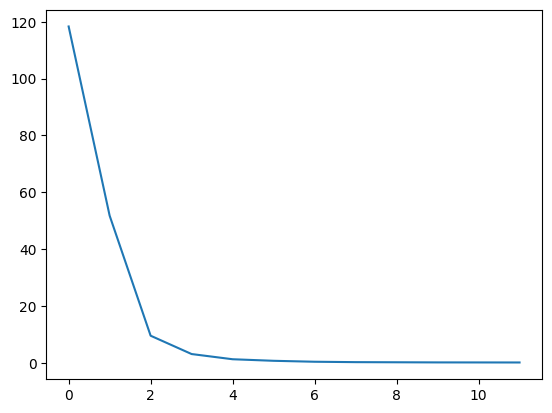

In [ ]:
plt.plot(tnr.history['loss'])

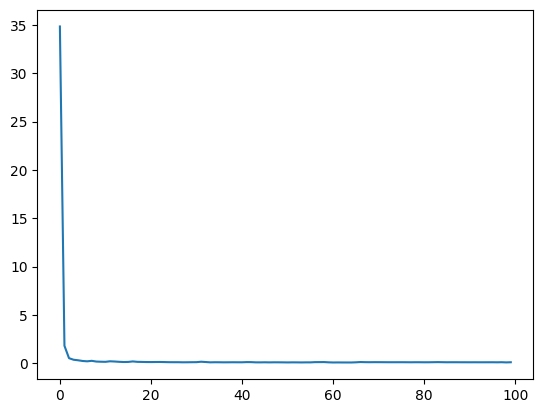

In [ ]:
plt.plot(best_model.history['loss'])